# 05 - QUEEN-NOQUEEN - SVM RBF Batch Evaluation

### Prerequisites

- todo

In [1]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 
from IPython.display import display
import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.audiodataset import AudioDataset # Main class for audio dataset handling


EXP_NAME = "05 - QUEEN-NOQUEEN - SVM RBF Batch Evaluation"


# Dataset name is the master key for dataset adressing
# Changing according to the dataset you want to process
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
display(ds.queryDataFrame(sql))

# Get pandas dataframe containing the columns we will need for this experiments
sql = "select mfcc20, apidictor, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql)

[2020-08-23/21:58:29.836|16.7%|65.8%|0.26GB] ------------------------------------------------------
[2020-08-23/21:58:29.837|00.0%|65.8%|0.26GB] DATASET NAME          : MAIN1000
[2020-08-23/21:58:29.837|00.0%|65.7%|0.26GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-08-23/21:58:29.837|00.0%|65.7%|0.26GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-08-23/21:58:29.837|00.0%|65.7%|0.26GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-08-23/21:58:29.837|00.0%|65.7%|0.26GB] NB SOURCE AUDIO FILES : 48
[2020-08-23/21:58:29.838|00.0%|65.7%|0.26GB] SAMPLE RATE           : 22050
[2020-08-23/21:58:29.838|00.0%|65.7%|0.26GB] DURATION              : 1.0
[2020-08-23/21:58:29.838|00.0%|65.7%|0.26GB] OVERLAP               : 0.0
[2020-08-23/21:58:29.838|00.0%|65.7%|0.26GB] NB AUDIO CHUNKS       : 24788
[2020-08-23/21:58:29.838|00.0%|65.7%|0.26GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from audace.jupytools import iprint, predestination
from audace.audiodataset import feature_serie_to_flat_np

FEATURE_NAME = 'mfcc20'
SET_FRAC = 1
TEST_FRAC = 0.99
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'
REPEAT=1000

def process_svm(param_C, param_gamma):
    # flatten features array
    iprint(">>>>> Flatten features")
    X = feature_serie_to_flat_np(df[FEATURE_NAME])

    # get labels
    y = df['queen']

    iprint(">>>>> Partition training/test")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC)

    # Here we perform fair scaling
    iprint(">>>>> Scale")
    scaler = StandardScaler()    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #Create a svm Classifier
    clf = svm.SVC(kernel='rbf', C=param_C, gamma=param_gamma)

    iprint('>>>>> Train')
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    iprint('>>>>> Predict')
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)


    iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
    iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
    iprint("Precision :",metrics.precision_score(y_test, y_pred))
    iprint("Recall    :",metrics.recall_score(y_test, y_pred))
    iprint("F-Measure :",metrics.f1_score(y_test, y_pred))
    
    return metrics.f1_score(y_test, y_pred)

def batch_svm(param_C, param_gamma, n=10):
    res = np.empty(n)
    for i in range(n):
        iprint(F"============== {i} ==============")
        res[i] = process_svm(param_C, param_gamma)

    return res


# Seed the various PRNGs
predestination()

# Get pandas dataframe containing the columns we will need for this experiment,
# shuffle it (and potentially truncate it to speed quick tests)
iprint(">>>>> Query features and labels")
sql = F"select {FEATURE_NAME}, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql).sample(frac=SET_FRAC)


fmeasures = batch_svm(C, GAMMA, n=REPEAT)   

iprint('DONE...')


[2020-08-23/22:04:47.099|05.5%|65.6%|0.36GB] >>>>> Query features and labels
[2020-08-23/22:04:47.451|15.2%|67.4%|0.36GB] ============== 0 ==============
[2020-08-23/22:04:47.451|00.0%|67.4%|0.36GB] >>>>> Flatten features
[2020-08-23/22:04:47.513|12.5%|68.0%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:04:47.544|15.4%|68.7%|0.47GB] >>>>> Scale
[2020-08-23/22:04:47.643|12.0%|68.8%|0.47GB] >>>>> Train
[2020-08-23/22:04:47.674|23.5%|68.8%|0.47GB] >>>>> Predict
[2020-08-23/22:04:49.937|13.1%|68.7%|0.47GB] Trained over 172 / Tested over 17033
[2020-08-23/22:04:49.940|00.0%|68.7%|0.47GB] Accuracy  : 0.956143955850408
[2020-08-23/22:04:49.947|22.2%|68.7%|0.47GB] Precision : 0.9934631978036345
[2020-08-23/22:04:49.955|00.0%|68.7%|0.47GB] Recall    : 0.9159836065573771
[2020-08-23/22:04:49.962|14.3%|68.7%|0.47GB] F-Measure : 0.9531514581373471
[2020-08-23/22:04:49.979|28.6%|67.3%|0.36GB] ============== 1 ==============
[2020-08-23/22:04:49.979|00.0%|67.3%|0.36GB] >>>>> Flatten features


[2020-08-23/22:05:16.820|15.5%|68.9%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:05:16.823|00.0%|68.9%|0.48GB] Accuracy  : 0.9537368637351025
[2020-08-23/22:05:16.830|00.0%|68.9%|0.48GB] Precision : 0.9965672035912332
[2020-08-23/22:05:16.838|14.3%|68.9%|0.48GB] Recall    : 0.908303249097473
[2020-08-23/22:05:16.846|00.0%|68.9%|0.48GB] F-Measure : 0.950390329891715
[2020-08-23/22:05:16.863|12.5%|67.5%|0.36GB] ============== 11 ==============
[2020-08-23/22:05:16.864|00.0%|67.5%|0.36GB] >>>>> Flatten features
[2020-08-23/22:05:16.928|17.6%|68.1%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:05:16.961|11.8%|68.7%|0.48GB] >>>>> Scale
[2020-08-23/22:05:17.069|14.8%|68.9%|0.48GB] >>>>> Train
[2020-08-23/22:05:17.101|18.2%|68.9%|0.48GB] >>>>> Predict
[2020-08-23/22:05:19.357|13.7%|68.8%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:05:19.359|00.0%|68.8%|0.48GB] Accuracy  : 0.9505665472905537
[2020-08-23/22:05:19.366|25.0%|68.8%|0.48GB] Precision : 0.99561

[2020-08-23/22:05:43.310|14.3%|68.4%|0.48GB] >>>>> Train
[2020-08-23/22:05:43.342|11.8%|68.4%|0.48GB] >>>>> Predict
[2020-08-23/22:05:45.704|14.1%|68.4%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:05:45.706|00.0%|68.4%|0.48GB] Accuracy  : 0.9545587976281337
[2020-08-23/22:05:45.714|28.6%|68.4%|0.48GB] Precision : 0.9908592321755028
[2020-08-23/22:05:45.722|00.0%|68.4%|0.48GB] Recall    : 0.9150988904968644
[2020-08-23/22:05:45.729|16.7%|68.4%|0.48GB] F-Measure : 0.951473354231975
[2020-08-23/22:05:45.747|20.0%|67.0%|0.37GB] ============== 22 ==============
[2020-08-23/22:05:45.748|00.0%|67.0%|0.37GB] >>>>> Flatten features
[2020-08-23/22:05:45.811|15.6%|67.6%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:05:45.844|13.3%|68.2%|0.48GB] >>>>> Scale
[2020-08-23/22:05:45.952|15.8%|68.4%|0.48GB] >>>>> Train
[2020-08-23/22:05:45.984|11.8%|68.4%|0.48GB] >>>>> Predict
[2020-08-23/22:05:48.395|13.5%|68.4%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:05:48.39

[2020-08-23/22:06:12.427|16.9%|68.3%|0.48GB] >>>>> Train
[2020-08-23/22:06:12.460|13.3%|68.3%|0.48GB] >>>>> Predict
[2020-08-23/22:06:15.057|14.7%|67.8%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:06:15.059|00.0%|67.8%|0.48GB] Accuracy  : 0.9539717019902542
[2020-08-23/22:06:15.067|00.0%|67.8%|0.48GB] Precision : 0.9918826918041372
[2020-08-23/22:06:15.074|25.0%|67.8%|0.48GB] Recall    : 0.9129910821884791
[2020-08-23/22:06:15.081|00.0%|67.8%|0.48GB] F-Measure : 0.9508032128514056
[2020-08-23/22:06:15.099|12.5%|66.4%|0.37GB] ============== 33 ==============
[2020-08-23/22:06:15.099|00.0%|66.4%|0.37GB] >>>>> Flatten features
[2020-08-23/22:06:15.166|17.5%|67.0%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:06:15.198|42.9%|67.7%|0.48GB] >>>>> Scale
[2020-08-23/22:06:15.309|22.4%|67.8%|0.48GB] >>>>> Train
[2020-08-23/22:06:15.342|20.0%|67.8%|0.48GB] >>>>> Predict
[2020-08-23/22:06:17.905|23.8%|68.3%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:06:17.9

[2020-08-23/22:06:44.234|23.4%|68.7%|0.48GB] >>>>> Train
[2020-08-23/22:06:44.271|20.8%|68.7%|0.48GB] >>>>> Predict
[2020-08-23/22:06:46.748|17.7%|68.8%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:06:46.750|00.0%|68.8%|0.48GB] Accuracy  : 0.9499794516526742
[2020-08-23/22:06:46.758|28.6%|68.8%|0.48GB] Precision : 0.9945608914831521
[2020-08-23/22:06:46.766|00.0%|68.8%|0.48GB] Recall    : 0.9023832450649976
[2020-08-23/22:06:46.774|20.0%|68.8%|0.48GB] F-Measure : 0.9462324876940553
[2020-08-23/22:06:46.792|18.2%|67.3%|0.37GB] ============== 44 ==============
[2020-08-23/22:06:46.793|00.0%|67.3%|0.37GB] >>>>> Flatten features
[2020-08-23/22:06:46.859|15.6%|68.0%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:06:46.893|12.5%|68.6%|0.48GB] >>>>> Scale
[2020-08-23/22:06:47.005|21.4%|68.8%|0.48GB] >>>>> Train
[2020-08-23/22:06:47.038|27.8%|68.8%|0.48GB] >>>>> Predict
[2020-08-23/22:06:49.345|15.0%|68.7%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:06:49.3

[2020-08-23/22:07:16.752|17.9%|69.3%|0.48GB] >>>>> Train
[2020-08-23/22:07:16.787|26.1%|69.3%|0.48GB] >>>>> Predict
[2020-08-23/22:07:19.715|21.5%|69.4%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:07:19.718|00.0%|69.4%|0.48GB] Accuracy  : 0.9654200669289027
[2020-08-23/22:07:19.731|50.0%|69.3%|0.48GB] Precision : 0.9879822896900696
[2020-08-23/22:07:19.744|37.5%|69.3%|0.48GB] Recall    : 0.9405105973025049
[2020-08-23/22:07:19.757|37.5%|69.3%|0.48GB] F-Measure : 0.9636621629958666
[2020-08-23/22:07:19.786|50.0%|67.9%|0.37GB] ============== 55 ==============
[2020-08-23/22:07:19.786|00.0%|67.9%|0.37GB] >>>>> Flatten features
[2020-08-23/22:07:19.891|26.8%|68.5%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:07:19.943|33.3%|69.2%|0.48GB] >>>>> Scale
[2020-08-23/22:07:20.115|36.8%|69.5%|0.48GB] >>>>> Train
[2020-08-23/22:07:20.161|16.7%|69.5%|0.48GB] >>>>> Predict
[2020-08-23/22:07:23.555|27.7%|70.0%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:07:23.5

[2020-08-23/22:07:49.415|15.9%|69.0%|0.48GB] >>>>> Train
[2020-08-23/22:07:49.449|12.5%|69.0%|0.48GB] >>>>> Predict
[2020-08-23/22:07:51.722|13.5%|69.0%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:07:51.724|50.0%|69.0%|0.48GB] Accuracy  : 0.9379439910761463
[2020-08-23/22:07:51.732|00.0%|69.0%|0.48GB] Precision : 0.9374018126888217
[2020-08-23/22:07:51.740|33.3%|69.0%|0.48GB] Recall    : 0.9350289296046287
[2020-08-23/22:07:51.748|00.0%|69.0%|0.48GB] F-Measure : 0.9362138676000241
[2020-08-23/22:07:51.767|11.1%|67.5%|0.37GB] ============== 66 ==============
[2020-08-23/22:07:51.767|00.0%|67.5%|0.37GB] >>>>> Flatten features
[2020-08-23/22:07:51.833|15.6%|68.2%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:07:51.866|19.0%|68.8%|0.48GB] >>>>> Scale
[2020-08-23/22:07:51.980|12.5%|68.9%|0.48GB] >>>>> Train
[2020-08-23/22:07:52.014|11.1%|68.9%|0.48GB] >>>>> Predict
[2020-08-23/22:07:54.476|14.6%|69.0%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:07:54.4

[2020-08-23/22:08:20.980|22.2%|69.6%|0.48GB] >>>>> Train
[2020-08-23/22:08:21.020|18.8%|69.6%|0.48GB] >>>>> Predict
[2020-08-23/22:08:23.728|18.1%|69.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:08:23.730|00.0%|69.6%|0.48GB] Accuracy  : 0.9526213820231315
[2020-08-23/22:08:23.738|00.0%|69.6%|0.48GB] Precision : 0.9830880454428091
[2020-08-23/22:08:23.746|25.0%|69.6%|0.48GB] Recall    : 0.9184658062959836
[2020-08-23/22:08:23.754|00.0%|69.6%|0.48GB] F-Measure : 0.949678867618632
[2020-08-23/22:08:23.773|25.0%|68.2%|0.37GB] ============== 77 ==============
[2020-08-23/22:08:23.773|00.0%|68.2%|0.37GB] >>>>> Flatten features
[2020-08-23/22:08:23.840|14.7%|68.8%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:08:23.873|12.5%|69.4%|0.48GB] >>>>> Scale
[2020-08-23/22:08:23.992|25.8%|69.4%|0.48GB] >>>>> Train
[2020-08-23/22:08:24.029|13.3%|69.4%|0.48GB] >>>>> Predict
[2020-08-23/22:08:26.939|18.6%|69.4%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:08:26.94

[2020-08-23/22:08:55.770|19.4%|70.1%|0.48GB] >>>>> Train
[2020-08-23/22:08:55.808|17.4%|70.1%|0.48GB] >>>>> Predict
[2020-08-23/22:08:58.397|14.0%|70.1%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:08:58.399|00.0%|70.1%|0.48GB] Accuracy  : 0.9505665472905537
[2020-08-23/22:08:58.407|00.0%|70.1%|0.48GB] Precision : 0.9910408432147563
[2020-08-23/22:08:58.413|25.0%|70.1%|0.48GB] Recall    : 0.906702025072324
[2020-08-23/22:08:58.421|00.0%|70.1%|0.48GB] F-Measure : 0.9469973561626589
[2020-08-23/22:08:58.438|16.7%|68.6%|0.37GB] ============== 88 ==============
[2020-08-23/22:08:58.439|00.0%|68.6%|0.37GB] >>>>> Flatten features
[2020-08-23/22:08:58.503|14.7%|69.3%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:08:58.535|13.3%|69.9%|0.48GB] >>>>> Scale
[2020-08-23/22:08:58.643|14.0%|70.1%|0.48GB] >>>>> Train
[2020-08-23/22:08:58.675|21.4%|70.1%|0.48GB] >>>>> Predict
[2020-08-23/22:09:01.302|22.4%|70.1%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:09:01.30

[2020-08-23/22:09:29.208|16.9%|69.9%|0.48GB] >>>>> Train
[2020-08-23/22:09:29.242|14.3%|69.9%|0.48GB] >>>>> Predict
[2020-08-23/22:09:31.919|21.7%|69.9%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:09:31.923|00.0%|69.9%|0.48GB] Accuracy  : 0.954147830681618
[2020-08-23/22:09:31.932|28.6%|69.9%|0.48GB] Precision : 0.993439181209815
[2020-08-23/22:09:31.942|00.0%|69.9%|0.48GB] Recall    : 0.911948927969164
[2020-08-23/22:09:31.951|12.5%|69.9%|0.48GB] F-Measure : 0.9509514538717578
[2020-08-23/22:09:31.972|12.5%|68.5%|0.37GB] ============== 99 ==============
[2020-08-23/22:09:31.972|00.0%|68.5%|0.37GB] >>>>> Flatten features
[2020-08-23/22:09:32.050|17.5%|69.1%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:09:32.088|13.6%|69.7%|0.48GB] >>>>> Scale
[2020-08-23/22:09:32.210|13.6%|69.9%|0.48GB] >>>>> Train
[2020-08-23/22:09:32.247|15.4%|69.9%|0.48GB] >>>>> Predict
[2020-08-23/22:09:34.895|17.2%|69.8%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:09:34.898|

[2020-08-23/22:10:03.786|25.0%|71.0%|0.48GB] >>>>> Train
[2020-08-23/22:10:03.824|16.7%|71.0%|0.48GB] >>>>> Predict
[2020-08-23/22:10:06.615|17.4%|71.0%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:10:06.618|28.6%|71.0%|0.48GB] Accuracy  : 0.9632478130687488
[2020-08-23/22:10:06.626|00.0%|71.0%|0.48GB] Precision : 0.9897881031401583
[2020-08-23/22:10:06.633|14.3%|71.0%|0.48GB] Recall    : 0.9342168674698795
[2020-08-23/22:10:06.641|00.0%|71.0%|0.48GB] F-Measure : 0.9611999504152721
[2020-08-23/22:10:06.660|12.5%|69.6%|0.37GB] ============== 110 ==============
[2020-08-23/22:10:06.660|00.0%|69.6%|0.37GB] >>>>> Flatten features
[2020-08-23/22:10:06.725|19.4%|70.2%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:10:06.758|16.7%|70.8%|0.48GB] >>>>> Scale
[2020-08-23/22:10:06.868|16.4%|71.0%|0.48GB] >>>>> Train
[2020-08-23/22:10:06.903|11.8%|71.0%|0.48GB] >>>>> Predict
[2020-08-23/22:10:09.774|20.5%|71.0%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:10:09.

[2020-08-23/22:10:38.072|25.0%|70.5%|0.48GB] >>>>> Train
[2020-08-23/22:10:38.109|20.0%|70.5%|0.48GB] >>>>> Predict
[2020-08-23/22:10:40.810|14.6%|70.3%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:10:40.812|00.0%|70.3%|0.48GB] Accuracy  : 0.9551458932660131
[2020-08-23/22:10:40.820|50.0%|70.3%|0.48GB] Precision : 0.989226375908619
[2020-08-23/22:10:40.829|00.0%|70.3%|0.48GB] Recall    : 0.9179715731149121
[2020-08-23/22:10:40.837|20.0%|70.3%|0.48GB] F-Measure : 0.9522678995376734
[2020-08-23/22:10:40.856|22.2%|68.9%|0.37GB] ============== 121 ==============
[2020-08-23/22:10:40.856|00.0%|68.9%|0.37GB] >>>>> Flatten features
[2020-08-23/22:10:40.923|21.2%|69.5%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:10:40.956|11.8%|70.2%|0.48GB] >>>>> Scale
[2020-08-23/22:10:41.071|17.5%|70.4%|0.48GB] >>>>> Train
[2020-08-23/22:10:41.106|11.8%|70.4%|0.48GB] >>>>> Predict
[2020-08-23/22:10:43.698|16.0%|70.4%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:10:43.7

[2020-08-23/22:11:10.409|23.2%|70.1%|0.48GB] >>>>> Train
[2020-08-23/22:11:10.444|43.5%|70.1%|0.48GB] >>>>> Predict
[2020-08-23/22:11:12.729|14.5%|70.1%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:11:12.732|00.0%|70.1%|0.48GB] Accuracy  : 0.9420536605413021
[2020-08-23/22:11:12.740|00.0%|70.1%|0.48GB] Precision : 0.992325299582604
[2020-08-23/22:11:12.748|28.6%|70.1%|0.48GB] Recall    : 0.8879518072289156
[2020-08-23/22:11:12.757|25.0%|70.1%|0.48GB] F-Measure : 0.9372416862720162
[2020-08-23/22:11:12.776|40.0%|68.7%|0.37GB] ============== 132 ==============
[2020-08-23/22:11:12.776|00.0%|68.7%|0.37GB] >>>>> Flatten features
[2020-08-23/22:11:12.843|14.3%|69.3%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:11:12.879|12.5%|70.0%|0.48GB] >>>>> Scale
[2020-08-23/22:11:13.002|26.2%|70.2%|0.48GB] >>>>> Train
[2020-08-23/22:11:13.038|18.2%|70.2%|0.48GB] >>>>> Predict
[2020-08-23/22:11:15.701|18.4%|69.8%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:11:15.7

[2020-08-23/22:11:43.907|19.6%|69.7%|0.48GB] >>>>> Train
[2020-08-23/22:11:43.944|18.2%|69.7%|0.48GB] >>>>> Predict
[2020-08-23/22:11:46.572|15.4%|69.7%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:11:46.574|00.0%|69.7%|0.48GB] Accuracy  : 0.9519168672576763
[2020-08-23/22:11:46.583|00.0%|69.7%|0.48GB] Precision : 0.9862033060002603
[2020-08-23/22:11:46.591|37.5%|69.7%|0.48GB] Recall    : 0.9139927623642943
[2020-08-23/22:11:46.600|33.3%|69.7%|0.48GB] F-Measure : 0.9487259750829523
[2020-08-23/22:11:46.619|20.0%|68.3%|0.37GB] ============== 143 ==============
[2020-08-23/22:11:46.619|00.0%|68.3%|0.37GB] >>>>> Flatten features
[2020-08-23/22:11:46.688|31.2%|68.9%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:11:46.723|18.8%|69.6%|0.48GB] >>>>> Scale
[2020-08-23/22:11:46.843|23.1%|69.8%|0.48GB] >>>>> Train
[2020-08-23/22:11:46.879|18.8%|69.8%|0.48GB] >>>>> Predict
[2020-08-23/22:11:49.579|16.2%|69.8%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:11:49.

[2020-08-23/22:12:19.621|37.5%|71.6%|0.48GB] >>>>> Scale
[2020-08-23/22:12:19.783|47.5%|71.8%|0.48GB] >>>>> Train
[2020-08-23/22:12:19.829|50.0%|71.8%|0.48GB] >>>>> Predict
[2020-08-23/22:12:22.993|33.4%|71.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:12:22.996|00.0%|71.6%|0.48GB] Accuracy  : 0.9335407737920507
[2020-08-23/22:12:23.003|00.0%|71.6%|0.48GB] Precision : 0.9425500370644923
[2020-08-23/22:12:23.012|37.5%|71.6%|0.48GB] Recall    : 0.9195998071359691
[2020-08-23/22:12:23.020|00.0%|71.6%|0.48GB] F-Measure : 0.9309334960341672
[2020-08-23/22:12:23.039|20.0%|70.1%|0.37GB] ============== 154 ==============
[2020-08-23/22:12:23.040|00.0%|70.1%|0.37GB] >>>>> Flatten features
[2020-08-23/22:12:23.106|18.8%|70.8%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:12:23.141|11.8%|71.4%|0.48GB] >>>>> Scale
[2020-08-23/22:12:23.253|14.3%|71.4%|0.48GB] >>>>> Train
[2020-08-23/22:12:23.290|21.1%|71.4%|0.48GB] >>>>> Predict
[2020-08-23/22:12:26.058|14.7%|71.3%|0.48GB] T

[2020-08-23/22:12:52.354|21.3%|72.8%|0.48GB] >>>>> Train
[2020-08-23/22:12:52.388|10.5%|72.8%|0.48GB] >>>>> Predict
[2020-08-23/22:12:54.982|16.0%|72.7%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:12:54.984|00.0%|72.7%|0.48GB] Accuracy  : 0.9564375036693478
[2020-08-23/22:12:54.993|25.0%|72.7%|0.48GB] Precision : 0.9915408641332639
[2020-08-23/22:12:55.001|00.0%|72.7%|0.48GB] Recall    : 0.9183944069431051
[2020-08-23/22:12:55.009|14.3%|72.7%|0.48GB] F-Measure : 0.953566958698373
[2020-08-23/22:12:55.028|28.6%|71.3%|0.37GB] ============== 165 ==============
[2020-08-23/22:12:55.028|00.0%|71.3%|0.37GB] >>>>> Flatten features
[2020-08-23/22:12:55.096|15.2%|71.9%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:12:55.130|23.5%|72.6%|0.48GB] >>>>> Scale
[2020-08-23/22:12:55.248|15.6%|72.7%|0.48GB] >>>>> Train
[2020-08-23/22:12:55.284|12.5%|72.7%|0.48GB] >>>>> Predict
[2020-08-23/22:12:57.912|14.7%|72.7%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:12:57.9

[2020-08-23/22:13:24.804|26.0%|72.8%|0.48GB] >>>>> Train
[2020-08-23/22:13:24.846|31.2%|72.8%|0.48GB] >>>>> Predict
[2020-08-23/22:13:27.666|19.0%|72.7%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:13:27.669|00.0%|72.7%|0.48GB] Accuracy  : 0.9566136323607115
[2020-08-23/22:13:27.678|25.0%|72.7%|0.48GB] Precision : 0.9812858052196054
[2020-08-23/22:13:27.688|00.0%|72.7%|0.48GB] Recall    : 0.9286746987951807
[2020-08-23/22:13:27.697|25.0%|72.7%|0.48GB] F-Measure : 0.9542556484060662
[2020-08-23/22:13:27.717|20.0%|71.2%|0.37GB] ============== 176 ==============
[2020-08-23/22:13:27.717|00.0%|71.2%|0.37GB] >>>>> Flatten features
[2020-08-23/22:13:27.795|19.0%|71.9%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:13:27.838|22.7%|72.5%|0.48GB] >>>>> Scale
[2020-08-23/22:13:27.983|17.6%|72.7%|0.48GB] >>>>> Train
[2020-08-23/22:13:28.023|21.1%|72.7%|0.48GB] >>>>> Predict
[2020-08-23/22:13:30.714|14.5%|72.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:13:30.

[2020-08-23/22:13:56.657|11.9%|72.5%|0.48GB] >>>>> Train
[2020-08-23/22:13:56.691|17.6%|72.4%|0.48GB] >>>>> Predict
[2020-08-23/22:13:59.067|13.6%|72.4%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:13:59.069|33.3%|72.4%|0.48GB] Accuracy  : 0.9547349263194974
[2020-08-23/22:13:59.077|00.0%|72.4%|0.48GB] Precision : 0.9894736842105263
[2020-08-23/22:13:59.085|16.7%|72.4%|0.48GB] Recall    : 0.916907514450867
[2020-08-23/22:13:59.093|00.0%|72.4%|0.48GB] F-Measure : 0.9518094880930058
[2020-08-23/22:13:59.111|14.3%|71.0%|0.37GB] ============== 187 ==============
[2020-08-23/22:13:59.112|00.0%|71.0%|0.37GB] >>>>> Flatten features
[2020-08-23/22:13:59.177|16.7%|71.6%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:13:59.210|10.5%|72.3%|0.48GB] >>>>> Scale
[2020-08-23/22:13:59.320|13.8%|72.5%|0.48GB] >>>>> Train
[2020-08-23/22:13:59.355|11.8%|72.5%|0.48GB] >>>>> Predict
[2020-08-23/22:14:02.090|14.0%|72.5%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:14:02.0

[2020-08-23/22:14:26.979|11.1%|72.4%|0.48GB] >>>>> Train
[2020-08-23/22:14:27.013|15.4%|72.4%|0.48GB] >>>>> Predict
[2020-08-23/22:14:29.598|12.9%|72.4%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:14:29.601|50.0%|72.4%|0.48GB] Accuracy  : 0.9517407385663125
[2020-08-23/22:14:29.609|00.0%|72.4%|0.48GB] Precision : 0.9759480783914483
[2020-08-23/22:14:29.617|12.5%|72.4%|0.48GB] Recall    : 0.9237533124548302
[2020-08-23/22:14:29.625|00.0%|72.4%|0.48GB] F-Measure : 0.9491336633663368
[2020-08-23/22:14:29.643|12.5%|70.9%|0.37GB] ============== 198 ==============
[2020-08-23/22:14:29.643|00.0%|70.9%|0.37GB] >>>>> Flatten features
[2020-08-23/22:14:29.708|15.6%|71.6%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:14:29.742|14.3%|72.2%|0.48GB] >>>>> Scale
[2020-08-23/22:14:29.853|14.3%|72.4%|0.48GB] >>>>> Train
[2020-08-23/22:14:29.886|10.5%|72.4%|0.48GB] >>>>> Predict
[2020-08-23/22:14:32.335|13.1%|72.4%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:14:32.

[2020-08-23/22:14:57.188|14.3%|71.3%|0.48GB] >>>>> Train
[2020-08-23/22:14:57.221|18.8%|71.3%|0.48GB] >>>>> Predict
[2020-08-23/22:14:59.581|13.4%|71.3%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:14:59.583|100.0%|71.3%|0.48GB] Accuracy  : 0.9378265719485704
[2020-08-23/22:14:59.591|28.6%|71.3%|0.48GB] Precision : 0.9085772403661431
[2020-08-23/22:14:59.599|50.0%|71.3%|0.48GB] Recall    : 0.9698431845597105
[2020-08-23/22:14:59.607|00.0%|71.3%|0.48GB] F-Measure : 0.9382110974969368
[2020-08-23/22:14:59.626|11.1%|69.8%|0.37GB] ============== 209 ==============
[2020-08-23/22:14:59.626|00.0%|69.8%|0.37GB] >>>>> Flatten features
[2020-08-23/22:14:59.692|16.1%|70.5%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:14:59.726|14.3%|71.1%|0.48GB] >>>>> Scale
[2020-08-23/22:14:59.839|16.7%|71.3%|0.48GB] >>>>> Train
[2020-08-23/22:14:59.870|12.5%|71.3%|0.48GB] >>>>> Predict
[2020-08-23/22:15:02.116|13.1%|71.3%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:15:02

[2020-08-23/22:15:27.189|14.5%|71.2%|0.48GB] >>>>> Train
[2020-08-23/22:15:27.222|16.7%|71.2%|0.48GB] >>>>> Predict
[2020-08-23/22:15:29.657|13.1%|71.2%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:15:29.660|00.0%|71.2%|0.48GB] Accuracy  : 0.9599600774966242
[2020-08-23/22:15:29.668|33.3%|71.2%|0.48GB] Precision : 0.9898392282958199
[2020-08-23/22:15:29.675|00.0%|71.2%|0.48GB] Recall    : 0.9273406434510182
[2020-08-23/22:15:29.683|12.5%|71.2%|0.48GB] F-Measure : 0.9575712330471569
[2020-08-23/22:15:29.701|28.6%|69.8%|0.37GB] ============== 220 ==============
[2020-08-23/22:15:29.701|00.0%|69.8%|0.37GB] >>>>> Flatten features
[2020-08-23/22:15:29.768|15.6%|70.4%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:15:29.801|11.8%|71.1%|0.48GB] >>>>> Scale
[2020-08-23/22:15:29.915|16.1%|71.2%|0.48GB] >>>>> Train
[2020-08-23/22:15:29.950|12.5%|71.2%|0.48GB] >>>>> Predict
[2020-08-23/22:15:32.558|13.1%|71.2%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:15:32.

[2020-08-23/22:15:57.480|12.7%|71.0%|0.48GB] >>>>> Train
[2020-08-23/22:15:57.514|12.5%|71.0%|0.48GB] >>>>> Predict
[2020-08-23/22:15:59.941|13.8%|71.0%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:15:59.944|33.3%|71.0%|0.48GB] Accuracy  : 0.9530323489696472
[2020-08-23/22:15:59.952|00.0%|71.0%|0.48GB] Precision : 0.9929059379926432
[2020-08-23/22:15:59.960|25.0%|71.0%|0.48GB] Recall    : 0.9101637764932563
[2020-08-23/22:15:59.968|00.0%|71.0%|0.48GB] F-Measure : 0.9497361146016587
[2020-08-23/22:15:59.986|16.7%|69.6%|0.37GB] ============== 231 ==============
[2020-08-23/22:15:59.986|00.0%|69.6%|0.37GB] >>>>> Flatten features
[2020-08-23/22:16:00.055|19.0%|70.2%|0.43GB] >>>>> Partition training/test
[2020-08-23/22:16:00.089|14.3%|70.9%|0.48GB] >>>>> Scale
[2020-08-23/22:16:00.205|12.1%|71.1%|0.48GB] >>>>> Train
[2020-08-23/22:16:00.238|26.7%|71.1%|0.48GB] >>>>> Predict
[2020-08-23/22:16:02.630|13.2%|71.0%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:16:02.

[2020-08-23/22:16:28.177|18.3%|70.7%|0.48GB] >>>>> Train
[2020-08-23/22:16:28.213|11.1%|70.7%|0.48GB] >>>>> Predict
[2020-08-23/22:16:31.487|34.4%|72.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:16:31.491|50.0%|72.6%|0.48GB] Accuracy  : 0.955204602829801
[2020-08-23/22:16:31.504|00.0%|72.6%|0.48GB] Precision : 0.9853073849722902
[2020-08-23/22:16:31.515|37.5%|72.6%|0.48GB] Recall    : 0.9217506631299734
[2020-08-23/22:16:31.525|25.0%|72.6%|0.48GB] F-Measure : 0.9524699433127763
[2020-08-23/22:16:31.549|37.5%|71.2%|0.37GB] ============== 242 ==============
[2020-08-23/22:16:31.550|00.0%|71.2%|0.37GB] >>>>> Flatten features
[2020-08-23/22:16:31.649|39.3%|71.7%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:16:31.697|70.8%|72.5%|0.48GB] >>>>> Scale
[2020-08-23/22:16:31.865|43.8%|72.7%|0.48GB] >>>>> Train
[2020-08-23/22:16:31.911|33.3%|72.7%|0.48GB] >>>>> Predict
[2020-08-23/22:16:35.314|32.4%|73.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:16:35.3

[2020-08-23/22:17:02.561|14.1%|75.2%|0.48GB] >>>>> Train
[2020-08-23/22:17:02.597|17.6%|75.2%|0.48GB] >>>>> Predict
[2020-08-23/22:17:05.494|22.0%|75.5%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:17:05.499|00.0%|75.5%|0.48GB] Accuracy  : 0.953267187224799
[2020-08-23/22:17:05.512|62.5%|75.5%|0.48GB] Precision : 0.986139896373057
[2020-08-23/22:17:05.524|40.0%|75.5%|0.48GB] Recall    : 0.9170079498915924
[2020-08-23/22:17:05.536|00.0%|75.4%|0.48GB] F-Measure : 0.9503183123205592
[2020-08-23/22:17:05.560|37.5%|74.0%|0.37GB] ============== 253 ==============
[2020-08-23/22:17:05.560|00.0%|74.0%|0.37GB] >>>>> Flatten features
[2020-08-23/22:17:05.649|29.2%|74.6%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:17:05.692|31.2%|75.3%|0.48GB] >>>>> Scale
[2020-08-23/22:17:05.851|34.1%|75.6%|0.48GB] >>>>> Train
[2020-08-23/22:17:05.902|25.0%|75.6%|0.48GB] >>>>> Predict
[2020-08-23/22:17:08.524|17.1%|75.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:17:08.52

[2020-08-23/22:17:34.540|19.4%|75.6%|0.48GB] >>>>> Train
[2020-08-23/22:17:34.574|11.1%|75.6%|0.48GB] >>>>> Predict
[2020-08-23/22:17:37.028|14.6%|75.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:17:37.031|00.0%|75.6%|0.48GB] Accuracy  : 0.9538542828626784
[2020-08-23/22:17:37.039|40.0%|75.6%|0.48GB] Precision : 0.9946088099934254
[2020-08-23/22:17:37.048|00.0%|75.6%|0.48GB] Recall    : 0.9103381875075219
[2020-08-23/22:17:37.056|12.5%|75.6%|0.48GB] F-Measure : 0.9506095262033429
[2020-08-23/22:17:37.075|25.0%|74.2%|0.37GB] ============== 264 ==============
[2020-08-23/22:17:37.076|00.0%|74.2%|0.37GB] >>>>> Flatten features
[2020-08-23/22:17:37.144|15.6%|74.8%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:17:37.178|19.0%|75.4%|0.48GB] >>>>> Scale
[2020-08-23/22:17:37.295|13.6%|75.6%|0.48GB] >>>>> Train
[2020-08-23/22:17:37.330|12.5%|75.6%|0.48GB] >>>>> Predict
[2020-08-23/22:17:39.903|13.6%|75.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:17:39.

[2020-08-23/22:18:05.585|19.0%|75.2%|0.48GB] >>>>> Train
[2020-08-23/22:18:05.623|21.1%|75.2%|0.48GB] >>>>> Predict
[2020-08-23/22:18:08.208|13.0%|75.2%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:18:08.210|33.3%|75.2%|0.48GB] Accuracy  : 0.9479246169200963
[2020-08-23/22:18:08.218|00.0%|75.2%|0.48GB] Precision : 0.9944044764188649
[2020-08-23/22:18:08.226|12.5%|75.2%|0.48GB] Recall    : 0.8983030448910819
[2020-08-23/22:18:08.234|00.0%|75.2%|0.48GB] F-Measure : 0.9439140056907999
[2020-08-23/22:18:08.253|37.5%|73.7%|0.37GB] ============== 275 ==============
[2020-08-23/22:18:08.253|00.0%|73.7%|0.37GB] >>>>> Flatten features
[2020-08-23/22:18:08.321|18.4%|74.4%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:18:08.355|11.8%|75.0%|0.48GB] >>>>> Scale
[2020-08-23/22:18:08.470|17.5%|75.2%|0.48GB] >>>>> Train
[2020-08-23/22:18:08.504|20.0%|75.2%|0.48GB] >>>>> Predict
[2020-08-23/22:18:11.218|14.1%|75.1%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:18:11.

[2020-08-23/22:18:37.062|22.0%|75.3%|0.48GB] >>>>> Train
[2020-08-23/22:18:37.098|18.8%|75.3%|0.48GB] >>>>> Predict
[2020-08-23/22:18:39.522|14.8%|75.3%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:18:39.525|00.0%|75.3%|0.48GB] Accuracy  : 0.9455762343685786
[2020-08-23/22:18:39.533|00.0%|75.3%|0.48GB] Precision : 0.9961005781901304
[2020-08-23/22:18:39.541|42.9%|75.3%|0.48GB] Recall    : 0.8918853840597158
[2020-08-23/22:18:39.550|00.0%|75.3%|0.48GB] F-Measure : 0.9411166867814267
[2020-08-23/22:18:39.568|27.3%|73.8%|0.37GB] ============== 286 ==============
[2020-08-23/22:18:39.569|00.0%|73.8%|0.37GB] >>>>> Flatten features
[2020-08-23/22:18:39.635|11.1%|74.5%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:18:39.670|12.5%|75.1%|0.48GB] >>>>> Scale
[2020-08-23/22:18:39.782|17.9%|75.3%|0.48GB] >>>>> Train
[2020-08-23/22:18:39.816|18.8%|75.3%|0.48GB] >>>>> Predict
[2020-08-23/22:18:42.432|14.0%|75.2%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:18:42.

[2020-08-23/22:19:09.281|14.8%|74.6%|0.48GB] >>>>> Train
[2020-08-23/22:19:09.311|17.6%|74.6%|0.48GB] >>>>> Predict
[2020-08-23/22:19:11.540|13.6%|74.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:19:11.542|00.0%|74.6%|0.48GB] Accuracy  : 0.954147830681618
[2020-08-23/22:19:11.550|00.0%|74.6%|0.48GB] Precision : 0.9839166237776634
[2020-08-23/22:19:11.557|16.7%|74.6%|0.48GB] Recall    : 0.9209924123810671
[2020-08-23/22:19:11.565|00.0%|74.6%|0.48GB] F-Measure : 0.9514152410575427
[2020-08-23/22:19:11.583|11.1%|73.2%|0.37GB] ============== 297 ==============
[2020-08-23/22:19:11.583|00.0%|73.2%|0.37GB] >>>>> Flatten features
[2020-08-23/22:19:11.650|18.4%|73.8%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:19:11.683|13.3%|74.5%|0.48GB] >>>>> Scale
[2020-08-23/22:19:11.792|11.9%|74.6%|0.48GB] >>>>> Train
[2020-08-23/22:19:11.827|14.3%|74.6%|0.48GB] >>>>> Predict
[2020-08-23/22:19:14.361|13.6%|74.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:19:14.3

[2020-08-23/22:19:39.929|16.4%|74.7%|0.48GB] >>>>> Train
[2020-08-23/22:19:39.964|10.5%|74.7%|0.48GB] >>>>> Predict
[2020-08-23/22:19:42.366|13.0%|74.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:19:42.368|00.0%|74.6%|0.48GB] Accuracy  : 0.9557916984676804
[2020-08-23/22:19:42.375|00.0%|74.6%|0.48GB] Precision : 0.99127944813224
[2020-08-23/22:19:42.382|16.7%|74.6%|0.48GB] Recall    : 0.9173693086003373
[2020-08-23/22:19:42.390|00.0%|74.6%|0.48GB] F-Measure : 0.9528933375039099
[2020-08-23/22:19:42.408|20.0%|73.2%|0.37GB] ============== 308 ==============
[2020-08-23/22:19:42.408|00.0%|73.2%|0.37GB] >>>>> Flatten features
[2020-08-23/22:19:42.473|15.6%|73.9%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:19:42.506|16.7%|74.5%|0.48GB] >>>>> Scale
[2020-08-23/22:19:42.619|22.6%|74.7%|0.48GB] >>>>> Train
[2020-08-23/22:19:42.652|21.4%|74.7%|0.48GB] >>>>> Predict
[2020-08-23/22:19:45.109|13.7%|74.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:19:45.11

[2020-08-23/22:20:11.097|16.1%|74.6%|0.48GB] >>>>> Train
[2020-08-23/22:20:11.132|19.0%|74.6%|0.48GB] >>>>> Predict
[2020-08-23/22:20:13.750|14.6%|74.6%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:20:13.753|00.0%|74.6%|0.48GB] Accuracy  : 0.9535607350437386
[2020-08-23/22:20:13.761|25.0%|74.6%|0.48GB] Precision : 0.9920104780615586
[2020-08-23/22:20:13.769|00.0%|74.6%|0.48GB] Recall    : 0.9120905587668593
[2020-08-23/22:20:13.777|14.3%|74.6%|0.48GB] F-Measure : 0.9503732981993851
[2020-08-23/22:20:13.796|33.3%|73.2%|0.37GB] ============== 319 ==============
[2020-08-23/22:20:13.796|00.0%|73.2%|0.37GB] >>>>> Flatten features
[2020-08-23/22:20:13.866|25.0%|73.8%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:20:13.900|20.0%|74.4%|0.48GB] >>>>> Scale
[2020-08-23/22:20:14.016|16.1%|74.5%|0.48GB] >>>>> Train
[2020-08-23/22:20:14.051|18.8%|74.5%|0.48GB] >>>>> Predict
[2020-08-23/22:20:16.687|14.1%|74.5%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:20:16.

[2020-08-23/22:20:42.587|23.4%|74.5%|0.48GB] >>>>> Train
[2020-08-23/22:20:42.623|12.5%|74.5%|0.48GB] >>>>> Predict
[2020-08-23/22:20:45.146|14.1%|74.5%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:20:45.149|33.3%|74.5%|0.48GB] Accuracy  : 0.9517994481301004
[2020-08-23/22:20:45.157|00.0%|74.5%|0.48GB] Precision : 0.9760417994137887
[2020-08-23/22:20:45.165|14.3%|74.5%|0.48GB] Recall    : 0.9236613603473227
[2020-08-23/22:20:45.173|00.0%|74.5%|0.48GB] F-Measure : 0.9491294380073114
[2020-08-23/22:20:45.191|12.5%|73.1%|0.37GB] ============== 330 ==============
[2020-08-23/22:20:45.191|00.0%|73.1%|0.37GB] >>>>> Flatten features
[2020-08-23/22:20:45.258|16.2%|73.7%|0.42GB] >>>>> Partition training/test
[2020-08-23/22:20:45.292|11.8%|74.3%|0.48GB] >>>>> Scale
[2020-08-23/22:20:45.407|12.1%|74.5%|0.48GB] >>>>> Train
[2020-08-23/22:20:45.441|18.8%|74.5%|0.48GB] >>>>> Predict
[2020-08-23/22:20:47.835|13.4%|74.5%|0.48GB] Trained over 172 / Tested over 17033
[2020-08-23/22:20:47.

[2020-08-23/22:21:13.510|15.9%|74.6%|0.48GB] >>>>> Train
[2020-08-23/22:21:13.544|13.3%|74.5%|0.48GB] >>>>> Predict
[2020-08-23/22:21:16.309|17.3%|72.9%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:21:16.312|00.0%|72.9%|0.35GB] Accuracy  : 0.97005812246815
[2020-08-23/22:21:16.322|28.6%|72.9%|0.35GB] Precision : 0.9873607808784883
[2020-08-23/22:21:16.332|00.0%|72.9%|0.35GB] Recall    : 0.9507169538498614
[2020-08-23/22:21:16.342|14.3%|72.9%|0.35GB] F-Measure : 0.9686924493554327
[2020-08-23/22:21:16.364|12.5%|71.4%|0.24GB] ============== 341 ==============
[2020-08-23/22:21:16.364|28.6%|71.4%|0.24GB] >>>>> Flatten features
[2020-08-23/22:21:16.440|11.8%|72.1%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:21:16.478|17.4%|72.7%|0.35GB] >>>>> Scale
[2020-08-23/22:21:16.602|15.4%|72.9%|0.35GB] >>>>> Train
[2020-08-23/22:21:16.639|12.5%|72.9%|0.35GB] >>>>> Predict
[2020-08-23/22:21:19.611|25.6%|73.6%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:21:19.61

[2020-08-23/22:21:45.803|16.7%|73.6%|0.35GB] >>>>> Train
[2020-08-23/22:21:45.837|11.8%|73.6%|0.35GB] >>>>> Predict
[2020-08-23/22:21:48.439|14.6%|73.6%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:21:48.442|00.0%|73.6%|0.35GB] Accuracy  : 0.9613691070275348
[2020-08-23/22:21:48.450|25.0%|73.6%|0.35GB] Precision : 0.9759681235213548
[2020-08-23/22:21:48.458|00.0%|73.6%|0.35GB] Recall    : 0.9439961459713356
[2020-08-23/22:21:48.466|14.3%|73.6%|0.35GB] F-Measure : 0.9597159299620424
[2020-08-23/22:21:48.485|22.2%|72.1%|0.24GB] ============== 352 ==============
[2020-08-23/22:21:48.485|00.0%|72.1%|0.24GB] >>>>> Flatten features
[2020-08-23/22:21:48.554|18.4%|72.8%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:21:48.589|11.1%|73.4%|0.35GB] >>>>> Scale
[2020-08-23/22:21:48.702|12.7%|73.6%|0.35GB] >>>>> Train
[2020-08-23/22:21:48.738|18.8%|73.6%|0.35GB] >>>>> Predict
[2020-08-23/22:21:51.339|13.5%|73.6%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:21:51.

[2020-08-23/22:22:19.128|12.5%|75.9%|0.35GB] >>>>> Train
[2020-08-23/22:22:19.163|20.0%|75.9%|0.35GB] >>>>> Predict
[2020-08-23/22:22:21.546|13.5%|75.8%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:22:21.549|00.0%|75.8%|0.35GB] Accuracy  : 0.9479246169200963
[2020-08-23/22:22:21.557|25.0%|75.8%|0.35GB] Precision : 0.9930786636496739
[2020-08-23/22:22:21.565|00.0%|75.8%|0.35GB] Recall    : 0.8993490838958534
[2020-08-23/22:22:21.573|37.5%|75.8%|0.35GB] F-Measure : 0.9438927193370865
[2020-08-23/22:22:21.592|25.0%|74.4%|0.24GB] ============== 363 ==============
[2020-08-23/22:22:21.592|00.0%|74.4%|0.24GB] >>>>> Flatten features
[2020-08-23/22:22:21.659|15.6%|75.0%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:22:21.693|12.5%|75.7%|0.35GB] >>>>> Scale
[2020-08-23/22:22:21.806|17.2%|75.8%|0.35GB] >>>>> Train
[2020-08-23/22:22:21.839|12.5%|75.8%|0.35GB] >>>>> Predict
[2020-08-23/22:22:24.294|15.0%|75.6%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:22:24.

[2020-08-23/22:22:51.698|17.7%|75.1%|0.35GB] >>>>> Train
[2020-08-23/22:22:51.733|11.1%|75.1%|0.35GB] >>>>> Predict
[2020-08-23/22:22:54.452|15.1%|75.0%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:22:54.454|00.0%|75.0%|0.35GB] Accuracy  : 0.9535607350437386
[2020-08-23/22:22:54.463|37.5%|75.0%|0.35GB] Precision : 0.9913612565445026
[2020-08-23/22:22:54.471|00.0%|75.0%|0.35GB] Recall    : 0.912640077117725
[2020-08-23/22:22:54.480|28.6%|75.0%|0.35GB] F-Measure : 0.9503732981993851
[2020-08-23/22:22:54.499|44.4%|73.6%|0.24GB] ============== 374 ==============
[2020-08-23/22:22:54.500|00.0%|73.6%|0.24GB] >>>>> Flatten features
[2020-08-23/22:22:54.568|15.6%|74.2%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:22:54.601|13.0%|74.9%|0.35GB] >>>>> Scale
[2020-08-23/22:22:54.715|12.3%|75.0%|0.35GB] >>>>> Train
[2020-08-23/22:22:54.752|25.0%|75.0%|0.35GB] >>>>> Predict
[2020-08-23/22:22:57.353|14.9%|74.9%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:22:57.3

[2020-08-23/22:23:23.286|12.5%|74.6%|0.35GB] >>>>> Train
[2020-08-23/22:23:23.321|18.2%|74.6%|0.35GB] >>>>> Predict
[2020-08-23/22:23:26.019|15.9%|74.7%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:23:26.021|40.0%|74.7%|0.35GB] Accuracy  : 0.9520929959490401
[2020-08-23/22:23:26.029|00.0%|74.7%|0.35GB] Precision : 0.9807272260053964
[2020-08-23/22:23:26.037|33.3%|74.7%|0.35GB] Recall    : 0.9197493673936619
[2020-08-23/22:23:26.046|00.0%|74.7%|0.35GB] F-Measure : 0.9492600422832982
[2020-08-23/22:23:26.066|25.0%|73.2%|0.24GB] ============== 385 ==============
[2020-08-23/22:23:26.066|00.0%|73.2%|0.24GB] >>>>> Flatten features
[2020-08-23/22:23:26.134|22.5%|73.9%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:23:26.168|26.7%|74.5%|0.35GB] >>>>> Scale
[2020-08-23/22:23:26.285|21.1%|74.7%|0.35GB] >>>>> Train
[2020-08-23/22:23:26.320|25.0%|74.7%|0.35GB] >>>>> Predict
[2020-08-23/22:23:28.921|16.0%|74.7%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:23:28.

[2020-08-23/22:23:54.824|19.0%|74.5%|0.35GB] >>>>> Train
[2020-08-23/22:23:54.859|12.5%|74.5%|0.35GB] >>>>> Predict
[2020-08-23/22:23:57.363|13.2%|74.5%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:23:57.366|28.6%|74.5%|0.35GB] Accuracy  : 0.9493923560147948
[2020-08-23/22:23:57.374|00.0%|74.5%|0.35GB] Precision : 0.9945529427394713
[2020-08-23/22:23:57.382|25.0%|74.5%|0.35GB] Recall    : 0.9011676899000842
[2020-08-23/22:23:57.389|00.0%|74.5%|0.35GB] F-Measure : 0.9455601869394973
[2020-08-23/22:23:57.408|12.5%|73.1%|0.24GB] ============== 396 ==============
[2020-08-23/22:23:57.409|00.0%|73.1%|0.24GB] >>>>> Flatten features
[2020-08-23/22:23:57.476|15.8%|73.7%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:23:57.509|12.5%|74.3%|0.35GB] >>>>> Scale
[2020-08-23/22:23:57.621|12.1%|74.5%|0.35GB] >>>>> Train
[2020-08-23/22:23:57.655|12.5%|74.5%|0.35GB] >>>>> Predict
[2020-08-23/22:24:00.230|15.4%|74.5%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:24:00.

[2020-08-23/22:24:26.360|15.8%|74.4%|0.35GB] >>>>> Train
[2020-08-23/22:24:26.394|31.2%|74.4%|0.35GB] >>>>> Predict
[2020-08-23/22:24:28.821|14.4%|74.4%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:24:28.824|00.0%|74.4%|0.35GB] Accuracy  : 0.953208477661011
[2020-08-23/22:24:28.832|00.0%|74.4%|0.35GB] Precision : 0.992656700760556
[2020-08-23/22:24:28.840|37.5%|74.4%|0.35GB] Recall    : 0.9108410540247864
[2020-08-23/22:24:28.849|00.0%|74.4%|0.35GB] F-Measure : 0.9499905879400138
[2020-08-23/22:24:28.868|37.5%|72.9%|0.24GB] ============== 407 ==============
[2020-08-23/22:24:28.869|00.0%|72.9%|0.24GB] >>>>> Flatten features
[2020-08-23/22:24:28.940|18.8%|73.6%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:24:28.974|31.2%|74.2%|0.35GB] >>>>> Scale
[2020-08-23/22:24:29.089|23.4%|74.4%|0.35GB] >>>>> Train
[2020-08-23/22:24:29.125|12.5%|74.4%|0.35GB] >>>>> Predict
[2020-08-23/22:24:31.756|14.0%|74.4%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:24:31.75

[2020-08-23/22:24:57.770|16.1%|73.5%|0.35GB] >>>>> Train
[2020-08-23/22:24:57.805|19.0%|73.4%|0.35GB] >>>>> Predict
[2020-08-23/22:25:00.290|14.6%|73.5%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:25:00.293|00.0%|73.5%|0.35GB] Accuracy  : 0.9593729818587448
[2020-08-23/22:25:00.304|40.0%|73.5%|0.35GB] Precision : 0.9889417513179889
[2020-08-23/22:25:00.313|00.0%|73.5%|0.35GB] Recall    : 0.9269615523683259
[2020-08-23/22:25:00.322|25.0%|73.5%|0.35GB] F-Measure : 0.9569491103645638
[2020-08-23/22:25:00.341|25.0%|72.0%|0.24GB] ============== 418 ==============
[2020-08-23/22:25:00.342|00.0%|72.0%|0.24GB] >>>>> Flatten features
[2020-08-23/22:25:00.410|18.8%|72.7%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:25:00.445|31.8%|73.3%|0.35GB] >>>>> Scale
[2020-08-23/22:25:00.561|25.9%|73.5%|0.35GB] >>>>> Train
[2020-08-23/22:25:00.595|18.8%|73.5%|0.35GB] >>>>> Predict
[2020-08-23/22:25:03.063|14.5%|73.4%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:25:03.

[2020-08-23/22:25:29.111|19.6%|73.5%|0.35GB] >>>>> Train
[2020-08-23/22:25:29.145|18.8%|73.5%|0.35GB] >>>>> Predict
[2020-08-23/22:25:31.614|13.1%|73.5%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:25:31.616|50.0%|73.5%|0.35GB] Accuracy  : 0.9410555979569072
[2020-08-23/22:25:31.624|00.0%|73.5%|0.35GB] Precision : 0.9580243810481337
[2020-08-23/22:25:31.632|14.3%|73.5%|0.35GB] Recall    : 0.9192089714216809
[2020-08-23/22:25:31.640|00.0%|73.5%|0.35GB] F-Measure : 0.9382153846153846
[2020-08-23/22:25:31.658|12.5%|72.0%|0.24GB] ============== 429 ==============
[2020-08-23/22:25:31.659|00.0%|72.0%|0.24GB] >>>>> Flatten features
[2020-08-23/22:25:31.724|16.7%|72.7%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:25:31.757|12.5%|73.3%|0.35GB] >>>>> Scale
[2020-08-23/22:25:31.867|20.0%|73.5%|0.35GB] >>>>> Train
[2020-08-23/22:25:31.900|12.5%|73.5%|0.35GB] >>>>> Predict
[2020-08-23/22:25:34.369|13.8%|73.5%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:25:34.

[2020-08-23/22:25:59.841|13.3%|73.4%|0.35GB] >>>>> Train
[2020-08-23/22:25:59.876|12.5%|73.4%|0.35GB] >>>>> Predict
[2020-08-23/22:26:02.616|16.0%|73.4%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:26:02.618|00.0%|73.4%|0.35GB] Accuracy  : 0.950155580344038
[2020-08-23/22:26:02.627|00.0%|73.4%|0.35GB] Precision : 0.981275826446281
[2020-08-23/22:26:02.635|14.3%|73.4%|0.35GB] Recall    : 0.9152113693845598
[2020-08-23/22:26:02.643|00.0%|73.4%|0.35GB] F-Measure : 0.9470929145634698
[2020-08-23/22:26:02.662|27.3%|72.0%|0.24GB] ============== 440 ==============
[2020-08-23/22:26:02.663|00.0%|72.0%|0.24GB] >>>>> Flatten features
[2020-08-23/22:26:02.734|11.1%|72.6%|0.29GB] >>>>> Partition training/test
[2020-08-23/22:26:02.768|12.5%|73.3%|0.35GB] >>>>> Scale
[2020-08-23/22:26:02.882|17.2%|73.4%|0.35GB] >>>>> Train
[2020-08-23/22:26:02.918|12.5%|73.4%|0.35GB] >>>>> Predict
[2020-08-23/22:26:05.470|14.4%|73.4%|0.35GB] Trained over 172 / Tested over 17033
[2020-08-23/22:26:05.47

[2020-08-23/22:26:32.186|13.3%|72.8%|0.29GB] >>>>> Train
[2020-08-23/22:26:32.221|18.8%|72.8%|0.29GB] >>>>> Predict
[2020-08-23/22:26:34.855|15.3%|72.8%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:26:34.858|00.0%|72.8%|0.29GB] Accuracy  : 0.9504491281629778
[2020-08-23/22:26:34.866|25.0%|72.8%|0.29GB] Precision : 0.9788271525728217
[2020-08-23/22:26:34.874|00.0%|72.8%|0.29GB] Recall    : 0.9182617069941014
[2020-08-23/22:26:34.882|14.3%|72.8%|0.29GB] F-Measure : 0.9475776397515527
[2020-08-23/22:26:34.902|33.3%|71.4%|0.17GB] ============== 451 ==============
[2020-08-23/22:26:34.902|00.0%|71.4%|0.17GB] >>>>> Flatten features
[2020-08-23/22:26:34.974|15.6%|72.0%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:26:35.009|08.3%|72.6%|0.29GB] >>>>> Scale
[2020-08-23/22:26:35.121|12.7%|72.8%|0.29GB] >>>>> Train
[2020-08-23/22:26:35.156|17.6%|72.8%|0.29GB] >>>>> Predict
[2020-08-23/22:26:37.671|14.9%|72.8%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:26:37.

[2020-08-23/22:27:03.616|16.4%|71.5%|0.29GB] >>>>> Train
[2020-08-23/22:27:03.650|15.8%|71.5%|0.29GB] >>>>> Predict
[2020-08-23/22:27:06.136|14.2%|71.5%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:27:06.139|00.0%|71.5%|0.29GB] Accuracy  : 0.9556155697763166
[2020-08-23/22:27:06.147|33.3%|71.5%|0.29GB] Precision : 0.9916481795641394
[2020-08-23/22:27:06.155|00.0%|71.5%|0.29GB] Recall    : 0.916536002894705
[2020-08-23/22:27:06.163|25.0%|71.5%|0.29GB] F-Measure : 0.9526137645731478
[2020-08-23/22:27:06.182|16.7%|70.1%|0.17GB] ============== 462 ==============
[2020-08-23/22:27:06.183|00.0%|70.1%|0.17GB] >>>>> Flatten features
[2020-08-23/22:27:06.250|15.6%|70.7%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:27:06.284|12.5%|71.4%|0.29GB] >>>>> Scale
[2020-08-23/22:27:06.397|14.3%|71.5%|0.29GB] >>>>> Train
[2020-08-23/22:27:06.431|11.8%|71.5%|0.29GB] >>>>> Predict
[2020-08-23/22:27:09.126|14.8%|71.5%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:27:09.1

[2020-08-23/22:27:36.515|12.3%|73.9%|0.29GB] >>>>> Train
[2020-08-23/22:27:36.549|20.0%|73.9%|0.29GB] >>>>> Predict
[2020-08-23/22:27:39.328|17.6%|73.8%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:27:39.331|00.0%|73.8%|0.29GB] Accuracy  : 0.9571420184348031
[2020-08-23/22:27:39.338|25.0%|73.8%|0.29GB] Precision : 0.9920696827873114
[2020-08-23/22:27:39.346|00.0%|73.8%|0.29GB] Recall    : 0.9193975903614457
[2020-08-23/22:27:39.354|12.5%|73.8%|0.29GB] F-Measure : 0.954352176088044
[2020-08-23/22:27:39.372|25.0%|72.4%|0.17GB] ============== 473 ==============
[2020-08-23/22:27:39.373|00.0%|72.4%|0.17GB] >>>>> Flatten features
[2020-08-23/22:27:39.441|15.6%|73.0%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:27:39.475|16.7%|73.6%|0.29GB] >>>>> Scale
[2020-08-23/22:27:39.586|16.1%|73.8%|0.29GB] >>>>> Train
[2020-08-23/22:27:39.621|12.5%|73.8%|0.29GB] >>>>> Predict
[2020-08-23/22:27:42.574|20.6%|74.0%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:27:42.5

[2020-08-23/22:28:09.838|15.6%|74.2%|0.29GB] >>>>> Train
[2020-08-23/22:28:09.873|12.5%|74.2%|0.29GB] >>>>> Predict
[2020-08-23/22:28:12.678|19.3%|74.6%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:28:12.681|00.0%|74.6%|0.29GB] Accuracy  : 0.9519755768214642
[2020-08-23/22:28:12.690|00.0%|74.6%|0.29GB] Precision : 0.9949775310600053
[2020-08-23/22:28:12.699|25.0%|74.6%|0.29GB] Recall    : 0.9061145883485797
[2020-08-23/22:28:12.708|00.0%|74.6%|0.29GB] F-Measure : 0.9484691949099155
[2020-08-23/22:28:12.729|31.2%|73.2%|0.17GB] ============== 484 ==============
[2020-08-23/22:28:12.729|00.0%|73.2%|0.17GB] >>>>> Flatten features
[2020-08-23/22:28:12.804|20.5%|73.8%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:28:12.841|11.8%|74.5%|0.29GB] >>>>> Scale
[2020-08-23/22:28:12.960|22.2%|74.6%|0.29GB] >>>>> Train
[2020-08-23/22:28:12.997|35.3%|74.6%|0.29GB] >>>>> Predict
[2020-08-23/22:28:15.767|14.7%|74.6%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:28:15.

[2020-08-23/22:28:42.930|15.9%|74.3%|0.29GB] >>>>> Train
[2020-08-23/22:28:42.965|11.8%|74.3%|0.29GB] >>>>> Predict
[2020-08-23/22:28:45.536|14.8%|74.3%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:28:45.539|37.5%|74.3%|0.29GB] Accuracy  : 0.950214289907826
[2020-08-23/22:28:45.548|00.0%|74.3%|0.29GB] Precision : 0.9920833883098034
[2020-08-23/22:28:45.556|12.5%|74.3%|0.29GB] Recall    : 0.9051402431684121
[2020-08-23/22:28:45.564|00.0%|74.3%|0.29GB] F-Measure : 0.9466196651139368
[2020-08-23/22:28:45.582|12.5%|72.9%|0.17GB] ============== 495 ==============
[2020-08-23/22:28:45.582|00.0%|72.9%|0.17GB] >>>>> Flatten features
[2020-08-23/22:28:45.651|18.4%|73.5%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:28:45.685|11.1%|74.1%|0.29GB] >>>>> Scale
[2020-08-23/22:28:45.799|12.5%|74.3%|0.29GB] >>>>> Train
[2020-08-23/22:28:45.834|18.2%|74.3%|0.29GB] >>>>> Predict
[2020-08-23/22:28:48.392|13.9%|74.3%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:28:48.3

[2020-08-23/22:29:15.676|22.8%|73.9%|0.28GB] >>>>> Train
[2020-08-23/22:29:15.712|20.0%|73.9%|0.28GB] >>>>> Predict
[2020-08-23/22:29:18.188|14.1%|73.9%|0.28GB] Trained over 172 / Tested over 17033
[2020-08-23/22:29:18.191|00.0%|73.9%|0.28GB] Accuracy  : 0.9526213820231315
[2020-08-23/22:29:18.199|28.6%|73.9%|0.28GB] Precision : 0.98370619423251
[2020-08-23/22:29:18.207|00.0%|73.9%|0.28GB] Recall    : 0.9178330115830116
[2020-08-23/22:29:18.215|12.5%|73.9%|0.28GB] F-Measure : 0.9496286124461644
[2020-08-23/22:29:18.233|25.0%|72.4%|0.17GB] ============== 506 ==============
[2020-08-23/22:29:18.234|00.0%|72.4%|0.17GB] >>>>> Flatten features
[2020-08-23/22:29:18.302|17.6%|73.1%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:29:18.336|09.1%|73.7%|0.28GB] >>>>> Scale
[2020-08-23/22:29:18.448|14.5%|73.9%|0.28GB] >>>>> Train
[2020-08-23/22:29:18.483|12.5%|73.9%|0.28GB] >>>>> Predict
[2020-08-23/22:29:21.074|13.7%|73.8%|0.28GB] Trained over 172 / Tested over 17033
[2020-08-23/22:29:21.07

[2020-08-23/22:29:46.959|15.3%|74.0%|0.28GB] >>>>> Train
[2020-08-23/22:29:46.994|10.0%|74.0%|0.28GB] >>>>> Predict
[2020-08-23/22:29:49.510|14.3%|74.0%|0.28GB] Trained over 172 / Tested over 17033
[2020-08-23/22:29:49.513|00.0%|74.0%|0.28GB] Accuracy  : 0.952151705512828
[2020-08-23/22:29:49.521|00.0%|74.0%|0.28GB] Precision : 0.9809670781893004
[2020-08-23/22:29:49.530|25.0%|74.0%|0.28GB] Recall    : 0.9195901145268234
[2020-08-23/22:29:49.538|16.7%|74.0%|0.28GB] F-Measure : 0.9492875365565304
[2020-08-23/22:29:49.557|22.2%|72.5%|0.17GB] ============== 517 ==============
[2020-08-23/22:29:49.558|00.0%|72.5%|0.17GB] >>>>> Flatten features
[2020-08-23/22:29:49.628|24.2%|73.2%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:29:49.663|26.1%|73.8%|0.28GB] >>>>> Scale
[2020-08-23/22:29:49.783|17.5%|74.0%|0.28GB] >>>>> Train
[2020-08-23/22:29:49.819|21.1%|74.0%|0.28GB] >>>>> Predict
[2020-08-23/22:29:52.549|16.6%|74.0%|0.28GB] Trained over 172 / Tested over 17033
[2020-08-23/22:29:52.5

[2020-08-23/22:30:19.310|44.0%|74.1%|0.28GB] >>>>> Scale
[2020-08-23/22:30:19.482|32.2%|74.2%|0.28GB] >>>>> Train
[2020-08-23/22:30:19.530|54.2%|74.2%|0.28GB] >>>>> Predict
[2020-08-23/22:30:22.519|19.1%|74.1%|0.28GB] Trained over 172 / Tested over 17033
[2020-08-23/22:30:22.522|50.0%|74.1%|0.28GB] Accuracy  : 0.9476310691011566
[2020-08-23/22:30:22.530|00.0%|74.1%|0.28GB] Precision : 0.9711159180557323
[2020-08-23/22:30:22.538|16.7%|74.1%|0.28GB] Recall    : 0.9198505483909847
[2020-08-23/22:30:22.546|00.0%|74.1%|0.28GB] F-Measure : 0.9447883139390938
[2020-08-23/22:30:22.565|11.1%|72.7%|0.17GB] ============== 528 ==============
[2020-08-23/22:30:22.566|00.0%|72.7%|0.17GB] >>>>> Flatten features
[2020-08-23/22:30:22.633|17.1%|73.3%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:30:22.667|19.0%|73.9%|0.28GB] >>>>> Scale
[2020-08-23/22:30:22.793|20.3%|74.1%|0.28GB] >>>>> Train
[2020-08-23/22:30:22.831|12.5%|74.1%|0.28GB] >>>>> Predict
[2020-08-23/22:30:25.583|16.3%|74.1%|0.28GB] T

[2020-08-23/22:30:52.294|15.9%|73.8%|0.28GB] >>>>> Train
[2020-08-23/22:30:52.330|11.8%|73.8%|0.28GB] >>>>> Predict
[2020-08-23/22:30:55.170|18.3%|73.9%|0.28GB] Trained over 172 / Tested over 17033
[2020-08-23/22:30:55.173|00.0%|73.9%|0.28GB] Accuracy  : 0.9425233370516057
[2020-08-23/22:30:55.181|25.0%|73.9%|0.28GB] Precision : 0.9958005960444324
[2020-08-23/22:30:55.189|00.0%|73.9%|0.28GB] Recall    : 0.8857693698035908
[2020-08-23/22:30:55.197|16.7%|73.9%|0.28GB] F-Measure : 0.9375677571583445
[2020-08-23/22:30:55.216|20.0%|72.4%|0.17GB] ============== 539 ==============
[2020-08-23/22:30:55.217|00.0%|72.4%|0.17GB] >>>>> Flatten features
[2020-08-23/22:30:55.285|16.1%|73.1%|0.23GB] >>>>> Partition training/test
[2020-08-23/22:30:55.319|14.3%|73.7%|0.28GB] >>>>> Scale
[2020-08-23/22:30:55.432|16.7%|73.9%|0.28GB] >>>>> Train
[2020-08-23/22:30:55.468|26.7%|73.9%|0.29GB] >>>>> Predict
[2020-08-23/22:30:58.387|18.3%|74.0%|0.29GB] Trained over 172 / Tested over 17033
[2020-08-23/22:30:58.

[2020-08-23/22:31:26.654|18.8%|74.2%|0.27GB] >>>>> Train
[2020-08-23/22:31:26.692|18.8%|74.2%|0.27GB] >>>>> Predict
[2020-08-23/22:31:29.481|15.0%|74.2%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:31:29.484|00.0%|74.2%|0.27GB] Accuracy  : 0.9554394410849527
[2020-08-23/22:31:29.492|28.6%|74.2%|0.27GB] Precision : 0.9951443569553806
[2020-08-23/22:31:29.500|00.0%|74.2%|0.27GB] Recall    : 0.9130644190246839
[2020-08-23/22:31:29.508|11.1%|74.2%|0.27GB] F-Measure : 0.9523390894819466
[2020-08-23/22:31:29.529|25.0%|72.8%|0.16GB] ============== 550 ==============
[2020-08-23/22:31:29.529|00.0%|72.8%|0.16GB] >>>>> Flatten features
[2020-08-23/22:31:29.603|23.7%|73.4%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:31:29.637|11.8%|74.1%|0.27GB] >>>>> Scale
[2020-08-23/22:31:29.753|15.8%|74.2%|0.27GB] >>>>> Train
[2020-08-23/22:31:29.788|29.2%|74.2%|0.27GB] >>>>> Predict
[2020-08-23/22:31:32.333|14.0%|74.2%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:31:32.

[2020-08-23/22:31:58.804|14.1%|74.2%|0.27GB] >>>>> Train
[2020-08-23/22:31:58.840|12.5%|74.2%|0.27GB] >>>>> Predict
[2020-08-23/22:32:01.340|15.5%|74.2%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:32:01.342|00.0%|74.2%|0.27GB] Accuracy  : 0.9482768743028239
[2020-08-23/22:32:01.351|40.0%|74.2%|0.27GB] Precision : 0.9825747724317295
[2020-08-23/22:32:01.359|00.0%|74.2%|0.27GB] Recall    : 0.9100325183668554
[2020-08-23/22:32:01.367|12.5%|74.2%|0.27GB] F-Measure : 0.9449133996123305
[2020-08-23/22:32:01.387|25.0%|72.8%|0.16GB] ============== 561 ==============
[2020-08-23/22:32:01.387|00.0%|72.8%|0.16GB] >>>>> Flatten features
[2020-08-23/22:32:01.457|15.6%|73.4%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:32:01.491|20.0%|74.1%|0.27GB] >>>>> Scale
[2020-08-23/22:32:01.603|15.0%|74.2%|0.27GB] >>>>> Train
[2020-08-23/22:32:01.638|12.5%|74.2%|0.27GB] >>>>> Predict
[2020-08-23/22:32:04.365|18.3%|74.4%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:32:04.

[2020-08-23/22:32:31.535|14.3%|74.5%|0.27GB] >>>>> Train
[2020-08-23/22:32:31.570|21.7%|74.5%|0.27GB] >>>>> Predict
[2020-08-23/22:32:34.206|16.1%|74.5%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:32:34.209|60.0%|74.5%|0.27GB] Accuracy  : 0.9526800915869195
[2020-08-23/22:32:34.218|00.0%|74.5%|0.27GB] Precision : 0.9868780044173054
[2020-08-23/22:32:34.226|14.3%|74.5%|0.27GB] Recall    : 0.9150704734369353
[2020-08-23/22:32:34.234|00.0%|74.5%|0.27GB] F-Measure : 0.9496187023377922
[2020-08-23/22:32:34.253|12.5%|73.1%|0.16GB] ============== 572 ==============
[2020-08-23/22:32:34.254|00.0%|73.1%|0.16GB] >>>>> Flatten features
[2020-08-23/22:32:34.327|22.5%|73.7%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:32:34.362|25.0%|74.4%|0.27GB] >>>>> Scale
[2020-08-23/22:32:34.478|17.2%|74.5%|0.27GB] >>>>> Train
[2020-08-23/22:32:34.514|18.8%|74.5%|0.27GB] >>>>> Predict
[2020-08-23/22:32:37.040|14.7%|74.5%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:32:37.

[2020-08-23/22:33:03.421|14.3%|74.4%|0.27GB] >>>>> Train
[2020-08-23/22:33:03.456|18.8%|74.4%|0.27GB] >>>>> Predict
[2020-08-23/22:33:05.982|14.6%|74.4%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:33:05.985|00.0%|74.4%|0.27GB] Accuracy  : 0.9543826689367698
[2020-08-23/22:33:05.993|75.0%|74.4%|0.27GB] Precision : 0.9880534995455136
[2020-08-23/22:33:06.001|00.0%|74.4%|0.27GB] Recall    : 0.9174101760308657
[2020-08-23/22:33:06.010|20.0%|74.4%|0.27GB] F-Measure : 0.9514223194748358
[2020-08-23/22:33:06.028|18.2%|73.0%|0.16GB] ============== 583 ==============
[2020-08-23/22:33:06.029|00.0%|73.0%|0.16GB] >>>>> Flatten features
[2020-08-23/22:33:06.099|15.6%|73.6%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:33:06.133|12.5%|74.3%|0.27GB] >>>>> Scale
[2020-08-23/22:33:06.245|14.3%|74.4%|0.27GB] >>>>> Train
[2020-08-23/22:33:06.279|31.2%|74.4%|0.27GB] >>>>> Predict
[2020-08-23/22:33:09.240|31.5%|74.8%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:33:09.

[2020-08-23/22:33:39.511|20.0%|75.5%|0.27GB] >>>>> Scale
[2020-08-23/22:33:39.665|16.0%|75.7%|0.27GB] >>>>> Train
[2020-08-23/22:33:39.709|25.0%|75.7%|0.27GB] >>>>> Predict
[2020-08-23/22:33:42.423|18.2%|75.7%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:33:42.424|00.0%|75.7%|0.27GB] Accuracy  : 0.9556742793401045
[2020-08-23/22:33:42.435|25.0%|75.7%|0.27GB] Precision : 0.9885877318116976
[2020-08-23/22:33:42.442|00.0%|75.7%|0.27GB] Recall    : 0.9195416164053076
[2020-08-23/22:33:42.451|37.5%|75.7%|0.27GB] F-Measure : 0.9528154490344354
[2020-08-23/22:33:42.471|25.0%|74.2%|0.16GB] ============== 594 ==============
[2020-08-23/22:33:42.471|00.0%|74.2%|0.16GB] >>>>> Flatten features
[2020-08-23/22:33:42.545|20.0%|74.9%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:33:42.581|18.8%|75.5%|0.27GB] >>>>> Scale
[2020-08-23/22:33:42.697|14.3%|75.7%|0.27GB] >>>>> Train
[2020-08-23/22:33:42.732|11.8%|75.7%|0.27GB] >>>>> Predict
[2020-08-23/22:33:45.757|25.1%|75.9%|0.27GB] T

[2020-08-23/22:34:13.853|15.0%|74.7%|0.27GB] >>>>> Train
[2020-08-23/22:34:13.887|12.5%|74.7%|0.27GB] >>>>> Predict
[2020-08-23/22:34:16.412|14.3%|74.7%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:34:16.414|00.0%|74.7%|0.27GB] Accuracy  : 0.9616626548464745
[2020-08-23/22:34:16.422|00.0%|74.7%|0.27GB] Precision : 0.993678235066443
[2020-08-23/22:34:16.430|14.3%|74.7%|0.27GB] Recall    : 0.9272814832651095
[2020-08-23/22:34:16.438|00.0%|74.7%|0.27GB] F-Measure : 0.9593323784019431
[2020-08-23/22:34:16.457|12.5%|73.3%|0.16GB] ============== 605 ==============
[2020-08-23/22:34:16.457|00.0%|73.3%|0.16GB] >>>>> Flatten features
[2020-08-23/22:34:16.525|17.9%|73.9%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:34:16.560|11.8%|74.5%|0.27GB] >>>>> Scale
[2020-08-23/22:34:16.673|19.6%|74.7%|0.27GB] >>>>> Train
[2020-08-23/22:34:16.706|18.8%|74.7%|0.27GB] >>>>> Predict
[2020-08-23/22:34:19.309|16.1%|74.7%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:34:19.3

[2020-08-23/22:34:46.404|12.5%|74.7%|0.27GB] >>>>> Train
[2020-08-23/22:34:46.436|11.8%|74.7%|0.27GB] >>>>> Predict
[2020-08-23/22:34:48.939|17.7%|74.8%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:34:48.942|00.0%|74.8%|0.27GB] Accuracy  : 0.9500968707802501
[2020-08-23/22:34:48.951|25.0%|74.8%|0.27GB] Precision : 0.9964071856287425
[2020-08-23/22:34:48.960|16.7%|74.8%|0.27GB] Recall    : 0.9009746119600529
[2020-08-23/22:34:48.969|00.0%|74.8%|0.27GB] F-Measure : 0.946290913686339
[2020-08-23/22:34:48.989|25.0%|73.3%|0.16GB] ============== 616 ==============
[2020-08-23/22:34:48.990|00.0%|73.3%|0.16GB] >>>>> Flatten features
[2020-08-23/22:34:49.063|11.4%|74.0%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:34:49.098|12.5%|74.6%|0.27GB] >>>>> Scale
[2020-08-23/22:34:49.250|33.8%|74.8%|0.27GB] >>>>> Train
[2020-08-23/22:34:49.290|18.2%|74.8%|0.27GB] >>>>> Predict
[2020-08-23/22:34:51.993|15.2%|74.8%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:34:51.9

[2020-08-23/22:35:17.290|16.4%|74.6%|0.27GB] >>>>> Train
[2020-08-23/22:35:17.323|11.1%|74.6%|0.27GB] >>>>> Predict
[2020-08-23/22:35:19.878|13.2%|74.6%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:35:19.880|00.0%|74.6%|0.27GB] Accuracy  : 0.9537955732988904
[2020-08-23/22:35:19.888|33.3%|74.6%|0.27GB] Precision : 0.9856477889837083
[2020-08-23/22:35:19.896|00.0%|74.6%|0.27GB] Recall    : 0.9185444029401133
[2020-08-23/22:35:19.904|12.5%|74.6%|0.27GB] F-Measure : 0.9509137404104036
[2020-08-23/22:35:19.922|40.0%|73.2%|0.16GB] ============== 627 ==============
[2020-08-23/22:35:19.922|00.0%|73.2%|0.16GB] >>>>> Flatten features
[2020-08-23/22:35:19.988|14.3%|73.8%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:35:20.021|18.8%|74.5%|0.27GB] >>>>> Scale
[2020-08-23/22:35:20.134|16.9%|74.6%|0.27GB] >>>>> Train
[2020-08-23/22:35:20.169|14.3%|74.6%|0.27GB] >>>>> Predict
[2020-08-23/22:35:22.848|15.9%|74.8%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:35:22.

[2020-08-23/22:35:49.444|15.3%|75.1%|0.27GB] >>>>> Train
[2020-08-23/22:35:49.481|19.0%|75.1%|0.27GB] >>>>> Predict
[2020-08-23/22:35:52.059|14.5%|75.1%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:35:52.062|00.0%|75.1%|0.27GB] Accuracy  : 0.9530323489696472
[2020-08-23/22:35:52.070|25.0%|75.1%|0.27GB] Precision : 0.9886541471048513
[2020-08-23/22:35:52.078|00.0%|75.1%|0.27GB] Recall    : 0.9140342416204486
[2020-08-23/22:35:52.087|16.7%|75.1%|0.27GB] F-Measure : 0.9498809672973312
[2020-08-23/22:35:52.106|30.0%|73.5%|0.16GB] ============== 638 ==============
[2020-08-23/22:35:52.107|00.0%|73.5%|0.16GB] >>>>> Flatten features
[2020-08-23/22:35:52.173|16.1%|74.2%|0.22GB] >>>>> Partition training/test
[2020-08-23/22:35:52.207|12.5%|74.8%|0.27GB] >>>>> Scale
[2020-08-23/22:35:52.321|14.5%|75.0%|0.27GB] >>>>> Train
[2020-08-23/22:35:52.355|11.8%|75.0%|0.27GB] >>>>> Predict
[2020-08-23/22:35:54.856|14.1%|74.9%|0.27GB] Trained over 172 / Tested over 17033
[2020-08-23/22:35:54.

[2020-08-23/22:36:22.901|17.2%|74.3%|0.26GB] >>>>> Train
[2020-08-23/22:36:22.938|25.0%|74.3%|0.26GB] >>>>> Predict
[2020-08-23/22:36:25.767|17.5%|74.3%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:36:25.769|00.0%|74.3%|0.26GB] Accuracy  : 0.9540304115540421
[2020-08-23/22:36:25.778|37.5%|74.3%|0.26GB] Precision : 0.9875389408099688
[2020-08-23/22:36:25.787|25.0%|74.3%|0.26GB] Recall    : 0.9171790235081374
[2020-08-23/22:36:25.795|00.0%|74.3%|0.26GB] F-Measure : 0.9510594412150759
[2020-08-23/22:36:25.814|12.5%|72.9%|0.15GB] ============== 649 ==============
[2020-08-23/22:36:25.814|00.0%|72.9%|0.15GB] >>>>> Flatten features
[2020-08-23/22:36:25.882|22.2%|73.5%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:36:25.916|25.0%|74.2%|0.26GB] >>>>> Scale
[2020-08-23/22:36:26.028|13.0%|74.3%|0.26GB] >>>>> Train
[2020-08-23/22:36:26.064|11.1%|74.3%|0.26GB] >>>>> Predict
[2020-08-23/22:36:28.857|23.2%|74.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:36:28.

[2020-08-23/22:36:55.840|13.8%|74.6%|0.26GB] >>>>> Train
[2020-08-23/22:36:55.880|25.0%|74.6%|0.26GB] >>>>> Predict
[2020-08-23/22:36:58.504|16.9%|74.5%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:36:58.506|66.7%|74.5%|0.26GB] Accuracy  : 0.9505078377267657
[2020-08-23/22:36:58.514|00.0%|74.5%|0.26GB] Precision : 0.9960101077270914
[2020-08-23/22:36:58.522|12.5%|74.5%|0.26GB] Recall    : 0.9020717899301374
[2020-08-23/22:36:58.530|00.0%|74.5%|0.26GB] F-Measure : 0.9467163896087478
[2020-08-23/22:36:58.548|14.3%|73.1%|0.15GB] ============== 660 ==============
[2020-08-23/22:36:58.548|00.0%|73.1%|0.15GB] >>>>> Flatten features
[2020-08-23/22:36:58.613|15.2%|73.7%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:36:58.647|13.6%|74.4%|0.26GB] >>>>> Scale
[2020-08-23/22:36:58.758|16.1%|74.5%|0.26GB] >>>>> Train
[2020-08-23/22:36:58.793|11.1%|74.5%|0.26GB] >>>>> Predict
[2020-08-23/22:37:01.349|14.4%|74.5%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:37:01.

[2020-08-23/22:37:28.714|29.5%|74.7%|0.26GB] >>>>> Train
[2020-08-23/22:37:28.750|11.8%|74.7%|0.26GB] >>>>> Predict
[2020-08-23/22:37:31.061|14.0%|74.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:37:31.063|00.0%|74.7%|0.26GB] Accuracy  : 0.9513884811835848
[2020-08-23/22:37:31.071|50.0%|74.7%|0.26GB] Precision : 0.9972085604147282
[2020-08-23/22:37:31.079|00.0%|74.7%|0.26GB] Recall    : 0.9028763990853291
[2020-08-23/22:37:31.087|14.3%|74.7%|0.26GB] F-Measure : 0.9477008590197069
[2020-08-23/22:37:31.103|22.2%|73.3%|0.15GB] ============== 671 ==============
[2020-08-23/22:37:31.104|00.0%|73.3%|0.15GB] >>>>> Flatten features
[2020-08-23/22:37:31.169|17.2%|73.9%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:37:31.203|11.1%|74.6%|0.26GB] >>>>> Scale
[2020-08-23/22:37:31.311|13.0%|74.7%|0.26GB] >>>>> Train
[2020-08-23/22:37:31.345|10.5%|74.7%|0.26GB] >>>>> Predict
[2020-08-23/22:37:34.018|14.4%|74.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:37:34.

[2020-08-23/22:37:59.599|15.3%|74.7%|0.26GB] >>>>> Train
[2020-08-23/22:37:59.633|10.0%|74.7%|0.26GB] >>>>> Predict
[2020-08-23/22:38:02.033|13.3%|74.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:38:02.035|00.0%|74.7%|0.26GB] Accuracy  : 0.9515646098749486
[2020-08-23/22:38:02.043|42.9%|74.7%|0.26GB] Precision : 0.9784891165172855
[2020-08-23/22:38:02.050|00.0%|74.7%|0.26GB] Recall    : 0.9208338354018556
[2020-08-23/22:38:02.058|16.7%|74.7%|0.26GB] F-Measure : 0.9487863926997331
[2020-08-23/22:38:02.076|20.0%|73.3%|0.15GB] ============== 682 ==============
[2020-08-23/22:38:02.076|00.0%|73.3%|0.15GB] >>>>> Flatten features
[2020-08-23/22:38:02.142|31.2%|73.9%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:38:02.175|12.5%|74.6%|0.26GB] >>>>> Scale
[2020-08-23/22:38:02.287|14.0%|74.7%|0.26GB] >>>>> Train
[2020-08-23/22:38:02.320|23.8%|74.7%|0.26GB] >>>>> Predict
[2020-08-23/22:38:04.866|13.9%|74.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:38:04.

[2020-08-23/22:38:31.868|14.1%|75.0%|0.26GB] >>>>> Train
[2020-08-23/22:38:31.905|11.8%|75.0%|0.26GB] >>>>> Predict
[2020-08-23/22:38:34.540|16.7%|75.0%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:38:34.542|00.0%|75.0%|0.26GB] Accuracy  : 0.9481007456114601
[2020-08-23/22:38:34.551|00.0%|75.0%|0.26GB] Precision : 0.9729281062444133
[2020-08-23/22:38:34.559|28.6%|75.0%|0.26GB] Recall    : 0.9189482571463032
[2020-08-23/22:38:34.567|00.0%|75.0%|0.26GB] F-Measure : 0.9451680932886739
[2020-08-23/22:38:34.585|17.6%|73.6%|0.15GB] ============== 693 ==============
[2020-08-23/22:38:34.586|00.0%|73.6%|0.15GB] >>>>> Flatten features
[2020-08-23/22:38:34.652|12.9%|74.2%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:38:34.685|11.8%|74.8%|0.26GB] >>>>> Scale
[2020-08-23/22:38:34.804|20.3%|75.0%|0.26GB] >>>>> Train
[2020-08-23/22:38:34.840|09.5%|75.0%|0.26GB] >>>>> Predict
[2020-08-23/22:38:37.350|13.8%|75.0%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:38:37.

[2020-08-23/22:39:03.683|23.0%|74.8%|0.26GB] >>>>> Train
[2020-08-23/22:39:03.720|20.0%|74.8%|0.26GB] >>>>> Predict
[2020-08-23/22:39:06.463|15.6%|74.8%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:39:06.466|00.0%|74.8%|0.26GB] Accuracy  : 0.9565549227969237
[2020-08-23/22:39:06.474|00.0%|74.8%|0.26GB] Precision : 0.9925723221266615
[2020-08-23/22:39:06.482|37.5%|74.8%|0.26GB] Recall    : 0.917710843373494
[2020-08-23/22:39:06.490|33.3%|74.8%|0.26GB] F-Measure : 0.9536747214223111
[2020-08-23/22:39:06.508|16.7%|73.4%|0.15GB] ============== 704 ==============
[2020-08-23/22:39:06.509|00.0%|73.4%|0.15GB] >>>>> Flatten features
[2020-08-23/22:39:06.576|15.6%|74.0%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:39:06.610|11.8%|74.6%|0.26GB] >>>>> Scale
[2020-08-23/22:39:06.722|12.5%|74.8%|0.26GB] >>>>> Train
[2020-08-23/22:39:06.756|21.1%|74.8%|0.26GB] >>>>> Predict
[2020-08-23/22:39:09.467|19.1%|74.9%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:39:09.4

[2020-08-23/22:39:36.991|13.8%|74.0%|0.26GB] >>>>> Train
[2020-08-23/22:39:37.025|12.5%|74.0%|0.26GB] >>>>> Predict
[2020-08-23/22:39:39.629|15.0%|73.9%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:39:39.631|50.0%|73.9%|0.26GB] Accuracy  : 0.9530323489696472
[2020-08-23/22:39:39.642|00.0%|73.9%|0.26GB] Precision : 0.9939465719173576
[2020-08-23/22:39:39.654|62.5%|73.9%|0.26GB] Recall    : 0.9092331768388107
[2020-08-23/22:39:39.663|33.3%|73.9%|0.26GB] F-Measure : 0.9497045140198667
[2020-08-23/22:39:39.688|20.0%|72.5%|0.15GB] ============== 715 ==============
[2020-08-23/22:39:39.688|00.0%|72.5%|0.15GB] >>>>> Flatten features
[2020-08-23/22:39:39.778|20.8%|73.1%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:39:39.821|22.7%|73.8%|0.26GB] >>>>> Scale
[2020-08-23/22:39:39.969|21.6%|73.9%|0.26GB] >>>>> Train
[2020-08-23/22:39:40.008|22.7%|73.9%|0.26GB] >>>>> Predict
[2020-08-23/22:39:42.784|18.6%|74.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:39:42.

[2020-08-23/22:40:11.391|13.2%|74.2%|0.26GB] >>>>> Train
[2020-08-23/22:40:11.426|15.8%|74.2%|0.26GB] >>>>> Predict
[2020-08-23/22:40:14.183|18.7%|74.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:40:14.185|00.0%|74.2%|0.26GB] Accuracy  : 0.9536194446075266
[2020-08-23/22:40:14.193|40.0%|74.2%|0.26GB] Precision : 0.9880410763031328
[2020-08-23/22:40:14.202|00.0%|74.2%|0.26GB] Recall    : 0.9158934811423063
[2020-08-23/22:40:14.210|16.7%|74.2%|0.26GB] F-Measure : 0.950600300150075
[2020-08-23/22:40:14.229|22.2%|72.8%|0.15GB] ============== 726 ==============
[2020-08-23/22:40:14.229|00.0%|72.8%|0.15GB] >>>>> Flatten features
[2020-08-23/22:40:14.297|18.8%|73.4%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:40:14.332|11.8%|74.0%|0.26GB] >>>>> Scale
[2020-08-23/22:40:14.446|23.1%|74.2%|0.26GB] >>>>> Train
[2020-08-23/22:40:14.481|31.2%|74.2%|0.26GB] >>>>> Predict
[2020-08-23/22:40:17.044|14.7%|74.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:40:17.0

[2020-08-23/22:40:45.224|17.7%|74.2%|0.26GB] >>>>> Train
[2020-08-23/22:40:45.262|20.0%|74.2%|0.26GB] >>>>> Predict
[2020-08-23/22:40:48.133|20.2%|74.3%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:40:48.136|00.0%|74.3%|0.26GB] Accuracy  : 0.9684729642458757
[2020-08-23/22:40:48.146|25.0%|74.3%|0.26GB] Precision : 0.9895373755199798
[2020-08-23/22:40:48.156|00.0%|74.3%|0.26GB] Recall    : 0.9453275529865125
[2020-08-23/22:40:48.166|12.5%|74.3%|0.26GB] F-Measure : 0.9669273880642976
[2020-08-23/22:40:48.188|25.0%|72.9%|0.15GB] ============== 737 ==============
[2020-08-23/22:40:48.189|00.0%|72.9%|0.15GB] >>>>> Flatten features
[2020-08-23/22:40:48.271|15.0%|73.5%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:40:48.311|18.2%|74.2%|0.26GB] >>>>> Scale
[2020-08-23/22:40:48.449|32.4%|74.6%|0.26GB] >>>>> Train
[2020-08-23/22:40:48.491|19.0%|74.6%|0.26GB] >>>>> Predict
[2020-08-23/22:40:51.238|16.2%|74.6%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:40:51.

[2020-08-23/22:41:17.282|21.1%|74.5%|0.26GB] >>>>> Train
[2020-08-23/22:41:17.319|31.8%|74.5%|0.26GB] >>>>> Predict
[2020-08-23/22:41:20.435|27.1%|73.3%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:41:20.438|00.0%|73.3%|0.26GB] Accuracy  : 0.954147830681618
[2020-08-23/22:41:20.447|28.6%|73.3%|0.26GB] Precision : 0.9925255704169945
[2020-08-23/22:41:20.456|00.0%|73.3%|0.26GB] Recall    : 0.9126974556855179
[2020-08-23/22:41:20.465|12.5%|73.3%|0.26GB] F-Measure : 0.9509391293422953
[2020-08-23/22:41:20.485|25.0%|71.8%|0.15GB] ============== 748 ==============
[2020-08-23/22:41:20.486|00.0%|71.8%|0.15GB] >>>>> Flatten features
[2020-08-23/22:41:20.556|16.2%|72.5%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:41:20.591|11.1%|73.1%|0.26GB] >>>>> Scale
[2020-08-23/22:41:20.706|14.0%|73.3%|0.26GB] >>>>> Train
[2020-08-23/22:41:20.741|19.0%|73.3%|0.26GB] >>>>> Predict
[2020-08-23/22:41:23.442|17.7%|73.3%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:41:23.4

[2020-08-23/22:41:49.799|16.1%|73.7%|0.26GB] >>>>> Train
[2020-08-23/22:41:49.834|19.0%|73.7%|0.26GB] >>>>> Predict
[2020-08-23/22:41:52.476|14.4%|73.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:41:52.478|00.0%|73.7%|0.26GB] Accuracy  : 0.952210415076616
[2020-08-23/22:41:52.486|00.0%|73.7%|0.26GB] Precision : 0.9889004962131105
[2020-08-23/22:41:52.494|33.3%|73.7%|0.26GB] Recall    : 0.912189833774994
[2020-08-23/22:41:52.502|00.0%|73.7%|0.26GB] F-Measure : 0.948997493734336
[2020-08-23/22:41:52.520|33.3%|72.2%|0.15GB] ============== 759 ==============
[2020-08-23/22:41:52.521|00.0%|72.2%|0.15GB] >>>>> Flatten features
[2020-08-23/22:41:52.587|15.6%|72.9%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:41:52.621|11.8%|73.5%|0.26GB] >>>>> Scale
[2020-08-23/22:41:52.733|12.5%|73.7%|0.26GB] >>>>> Train
[2020-08-23/22:41:52.766|11.8%|73.7%|0.26GB] >>>>> Predict
[2020-08-23/22:41:55.306|13.7%|73.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:41:55.309

[2020-08-23/22:42:20.824|14.3%|73.7%|0.26GB] >>>>> Train
[2020-08-23/22:42:20.858|25.0%|73.6%|0.26GB] >>>>> Predict
[2020-08-23/22:42:23.348|15.2%|73.6%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:42:23.350|25.0%|73.6%|0.26GB] Accuracy  : 0.9461046204426701
[2020-08-23/22:42:23.358|00.0%|73.6%|0.26GB] Precision : 0.9645604742086014
[2020-08-23/22:42:23.366|33.3%|73.6%|0.26GB] Recall    : 0.9231140615570308
[2020-08-23/22:42:23.373|00.0%|73.6%|0.26GB] F-Measure : 0.9433822622425065
[2020-08-23/22:42:23.391|12.5%|72.2%|0.15GB] ============== 770 ==============
[2020-08-23/22:42:23.391|00.0%|72.2%|0.15GB] >>>>> Flatten features
[2020-08-23/22:42:23.457|16.1%|72.9%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:42:23.492|13.0%|73.5%|0.26GB] >>>>> Scale
[2020-08-23/22:42:23.607|15.5%|73.6%|0.26GB] >>>>> Train
[2020-08-23/22:42:23.642|14.3%|73.6%|0.26GB] >>>>> Predict
[2020-08-23/22:42:26.243|13.8%|73.6%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:42:26.

[2020-08-23/22:42:52.149|14.1%|74.6%|0.26GB] >>>>> Train
[2020-08-23/22:42:52.185|14.3%|74.6%|0.26GB] >>>>> Predict
[2020-08-23/22:42:55.081|17.3%|74.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:42:55.084|33.3%|74.7%|0.26GB] Accuracy  : 0.9663594199495098
[2020-08-23/22:42:55.092|00.0%|74.7%|0.26GB] Precision : 0.9828664332166083
[2020-08-23/22:42:55.100|14.3%|74.7%|0.26GB] Recall    : 0.9474382157926462
[2020-08-23/22:42:55.108|00.0%|74.7%|0.26GB] F-Measure : 0.9648272052053282
[2020-08-23/22:42:55.127|14.3%|73.2%|0.15GB] ============== 781 ==============
[2020-08-23/22:42:55.127|00.0%|73.2%|0.15GB] >>>>> Flatten features
[2020-08-23/22:42:55.193|15.0%|73.9%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:42:55.228|13.3%|74.5%|0.26GB] >>>>> Scale
[2020-08-23/22:42:55.341|13.8%|74.7%|0.26GB] >>>>> Train
[2020-08-23/22:42:55.375|23.5%|74.7%|0.26GB] >>>>> Predict
[2020-08-23/22:42:58.213|20.6%|74.4%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:42:58.

[2020-08-23/22:43:24.244|18.6%|74.3%|0.26GB] >>>>> Train
[2020-08-23/22:43:24.277|12.5%|74.3%|0.26GB] >>>>> Predict
[2020-08-23/22:43:26.655|14.2%|74.4%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:43:26.658|00.0%|74.4%|0.26GB] Accuracy  : 0.9537368637351025
[2020-08-23/22:43:26.665|20.0%|74.4%|0.26GB] Precision : 0.9891927083333333
[2020-08-23/22:43:26.673|00.0%|74.4%|0.26GB] Recall    : 0.9150807034449531
[2020-08-23/22:43:26.680|14.3%|74.4%|0.26GB] F-Measure : 0.9506945313477663
[2020-08-23/22:43:26.698|25.0%|73.0%|0.15GB] ============== 792 ==============
[2020-08-23/22:43:26.698|00.0%|73.0%|0.15GB] >>>>> Flatten features
[2020-08-23/22:43:26.763|15.2%|73.6%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:43:26.796|12.5%|74.2%|0.26GB] >>>>> Scale
[2020-08-23/22:43:26.907|19.6%|74.4%|0.26GB] >>>>> Train
[2020-08-23/22:43:26.940|18.8%|74.4%|0.26GB] >>>>> Predict
[2020-08-23/22:43:29.435|15.1%|73.8%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:43:29.

[2020-08-23/22:43:54.407|19.3%|73.6%|0.26GB] >>>>> Train
[2020-08-23/22:43:54.441|18.8%|73.6%|0.26GB] >>>>> Predict
[2020-08-23/22:43:56.971|13.0%|73.6%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:43:56.973|00.0%|73.6%|0.26GB] Accuracy  : 0.9579639523278342
[2020-08-23/22:43:56.981|25.0%|73.6%|0.26GB] Precision : 0.9854033290653009
[2020-08-23/22:43:56.989|00.0%|73.6%|0.26GB] Recall    : 0.9274523981682333
[2020-08-23/22:43:56.997|16.7%|73.6%|0.26GB] F-Measure : 0.9555500372485722
[2020-08-23/22:43:57.016|14.3%|72.2%|0.15GB] ============== 803 ==============
[2020-08-23/22:43:57.016|00.0%|72.2%|0.15GB] >>>>> Flatten features
[2020-08-23/22:43:57.080|15.2%|72.8%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:43:57.114|11.8%|73.5%|0.26GB] >>>>> Scale
[2020-08-23/22:43:57.226|23.8%|73.6%|0.26GB] >>>>> Train
[2020-08-23/22:43:57.259|11.1%|73.6%|0.26GB] >>>>> Predict
[2020-08-23/22:43:59.631|13.3%|73.6%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:43:59.

[2020-08-23/22:44:25.530|16.7%|73.7%|0.26GB] >>>>> Train
[2020-08-23/22:44:25.563|12.5%|73.7%|0.26GB] >>>>> Predict
[2020-08-23/22:44:27.923|13.3%|73.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:44:27.926|00.0%|73.7%|0.26GB] Accuracy  : 0.952151705512828
[2020-08-23/22:44:27.933|28.6%|73.7%|0.26GB] Precision : 0.9850901076105277
[2020-08-23/22:44:27.941|00.0%|73.7%|0.26GB] Recall    : 0.915642323451434
[2020-08-23/22:44:27.949|12.5%|73.7%|0.26GB] F-Measure : 0.9490974954718631
[2020-08-23/22:44:27.966|33.3%|72.3%|0.15GB] ============== 814 ==============
[2020-08-23/22:44:27.967|00.0%|72.3%|0.15GB] >>>>> Flatten features
[2020-08-23/22:44:28.031|15.6%|72.9%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:44:28.065|12.5%|73.6%|0.26GB] >>>>> Scale
[2020-08-23/22:44:28.179|15.4%|73.7%|0.26GB] >>>>> Train
[2020-08-23/22:44:28.213|13.3%|73.7%|0.26GB] >>>>> Predict
[2020-08-23/22:44:30.626|13.0%|73.6%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:44:30.62

[2020-08-23/22:44:56.863|17.9%|73.7%|0.26GB] >>>>> Train
[2020-08-23/22:44:56.898|19.0%|73.7%|0.26GB] >>>>> Predict
[2020-08-23/22:44:59.330|15.1%|73.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:44:59.333|00.0%|73.2%|0.26GB] Accuracy  : 0.9100569482768743
[2020-08-23/22:44:59.340|33.3%|73.2%|0.26GB] Precision : 0.8638031513058494
[2020-08-23/22:44:59.348|33.3%|73.2%|0.26GB] Recall    : 0.9673676577229877
[2020-08-23/22:44:59.357|00.0%|73.2%|0.26GB] F-Measure : 0.9126567844925885
[2020-08-23/22:44:59.375|12.5%|71.7%|0.15GB] ============== 825 ==============
[2020-08-23/22:44:59.375|00.0%|71.7%|0.15GB] >>>>> Flatten features
[2020-08-23/22:44:59.442|28.6%|72.4%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:44:59.477|11.1%|73.0%|0.26GB] >>>>> Scale
[2020-08-23/22:44:59.594|13.8%|73.2%|0.26GB] >>>>> Train
[2020-08-23/22:44:59.628|16.7%|73.2%|0.26GB] >>>>> Predict
[2020-08-23/22:45:02.059|13.4%|73.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:45:02.

[2020-08-23/22:45:27.200|12.3%|73.1%|0.26GB] >>>>> Train
[2020-08-23/22:45:27.234|14.3%|73.1%|0.26GB] >>>>> Predict
[2020-08-23/22:45:29.789|13.5%|73.1%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:45:29.792|00.0%|73.1%|0.26GB] Accuracy  : 0.943286561380849
[2020-08-23/22:45:29.800|00.0%|73.1%|0.26GB] Precision : 0.9927409598064256
[2020-08-23/22:45:29.808|28.6%|73.1%|0.26GB] Recall    : 0.8900807520790647
[2020-08-23/22:45:29.815|00.0%|73.1%|0.26GB] F-Measure : 0.9386120996441281
[2020-08-23/22:45:29.834|27.3%|71.7%|0.15GB] ============== 836 ==============
[2020-08-23/22:45:29.834|00.0%|71.7%|0.15GB] >>>>> Flatten features
[2020-08-23/22:45:29.899|11.1%|72.3%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:45:29.932|13.3%|73.0%|0.26GB] >>>>> Scale
[2020-08-23/22:45:30.049|12.3%|73.1%|0.26GB] >>>>> Train
[2020-08-23/22:45:30.083|17.6%|73.1%|0.26GB] >>>>> Predict
[2020-08-23/22:45:32.589|13.4%|73.1%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:45:32.5

[2020-08-23/22:45:57.787|16.1%|73.2%|0.26GB] >>>>> Train
[2020-08-23/22:45:57.822|10.0%|73.2%|0.26GB] >>>>> Predict
[2020-08-23/22:46:00.447|14.8%|73.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:46:00.450|00.0%|73.2%|0.26GB] Accuracy  : 0.9553807315211648
[2020-08-23/22:46:00.458|00.0%|73.2%|0.26GB] Precision : 0.994359176177358
[2020-08-23/22:46:00.466|28.6%|73.2%|0.26GB] Recall    : 0.9135832228516331
[2020-08-23/22:46:00.475|25.0%|73.2%|0.26GB] F-Measure : 0.9522613065326633
[2020-08-23/22:46:00.492|18.2%|71.8%|0.15GB] ============== 847 ==============
[2020-08-23/22:46:00.493|00.0%|71.8%|0.15GB] >>>>> Flatten features
[2020-08-23/22:46:00.561|14.7%|72.4%|0.21GB] >>>>> Partition training/test
[2020-08-23/22:46:00.596|13.3%|73.0%|0.26GB] >>>>> Scale
[2020-08-23/22:46:00.714|14.5%|73.2%|0.26GB] >>>>> Train
[2020-08-23/22:46:00.749|11.8%|73.2%|0.26GB] >>>>> Predict
[2020-08-23/22:46:03.298|14.8%|73.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:46:03.3

[2020-08-23/22:46:29.299|28.4%|72.5%|0.26GB] >>>>> Train
[2020-08-23/22:46:29.339|29.2%|72.4%|0.26GB] >>>>> Predict
[2020-08-23/22:46:31.879|14.8%|71.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:46:31.882|50.0%|71.2%|0.26GB] Accuracy  : 0.956143955850408
[2020-08-23/22:46:31.892|00.0%|71.2%|0.26GB] Precision : 0.9921793534932221
[2020-08-23/22:46:31.901|16.7%|71.2%|0.26GB] Recall    : 0.9172189420412098
[2020-08-23/22:46:31.910|00.0%|71.2%|0.26GB] F-Measure : 0.9532277252520192
[2020-08-23/22:46:31.929|21.4%|69.8%|0.15GB] ============== 858 ==============
[2020-08-23/22:46:31.930|00.0%|69.8%|0.15GB] >>>>> Flatten features
[2020-08-23/22:46:32.000|14.3%|70.4%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:46:32.036|13.3%|71.0%|0.26GB] >>>>> Scale
[2020-08-23/22:46:32.160|15.6%|71.2%|0.26GB] >>>>> Train
[2020-08-23/22:46:32.196|16.7%|71.2%|0.26GB] >>>>> Predict
[2020-08-23/22:46:34.671|15.5%|71.5%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:46:34.6

[2020-08-23/22:47:00.833|26.3%|71.8%|0.26GB] >>>>> Train
[2020-08-23/22:47:00.866|19.0%|71.8%|0.26GB] >>>>> Predict
[2020-08-23/22:47:03.426|12.8%|71.8%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:47:03.429|33.3%|71.8%|0.26GB] Accuracy  : 0.9557329889038925
[2020-08-23/22:47:03.437|00.0%|71.8%|0.26GB] Precision : 0.9921803727355663
[2020-08-23/22:47:03.444|14.3%|71.8%|0.26GB] Recall    : 0.9164560009630432
[2020-08-23/22:47:03.452|00.0%|71.8%|0.26GB] F-Measure : 0.9528160200250314
[2020-08-23/22:47:03.470|16.7%|70.4%|0.15GB] ============== 869 ==============
[2020-08-23/22:47:03.471|00.0%|70.4%|0.15GB] >>>>> Flatten features
[2020-08-23/22:47:03.535|14.7%|71.0%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:47:03.568|13.3%|71.6%|0.26GB] >>>>> Scale
[2020-08-23/22:47:03.682|14.3%|71.8%|0.26GB] >>>>> Train
[2020-08-23/22:47:03.715|13.3%|71.8%|0.26GB] >>>>> Predict
[2020-08-23/22:47:06.129|13.5%|71.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:47:06.

[2020-08-23/22:47:31.509|15.8%|71.6%|0.26GB] >>>>> Train
[2020-08-23/22:47:31.543|12.5%|71.6%|0.26GB] >>>>> Predict
[2020-08-23/22:47:34.080|15.3%|70.9%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:47:34.082|00.0%|70.9%|0.26GB] Accuracy  : 0.9529149298420713
[2020-08-23/22:47:34.090|28.6%|70.9%|0.26GB] Precision : 0.9903293256664925
[2020-08-23/22:47:34.097|00.0%|70.9%|0.26GB] Recall    : 0.9123525162533108
[2020-08-23/22:47:34.106|14.3%|70.9%|0.26GB] F-Measure : 0.9497430755733801
[2020-08-23/22:47:34.123|25.0%|69.5%|0.15GB] ============== 880 ==============
[2020-08-23/22:47:34.124|00.0%|69.5%|0.15GB] >>>>> Flatten features
[2020-08-23/22:47:34.188|15.6%|70.1%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:47:34.220|17.6%|70.7%|0.26GB] >>>>> Scale
[2020-08-23/22:47:34.333|23.3%|70.9%|0.26GB] >>>>> Train
[2020-08-23/22:47:34.368|15.8%|70.9%|0.26GB] >>>>> Predict
[2020-08-23/22:47:37.096|15.7%|70.9%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:47:37.

[2020-08-23/22:48:03.407|15.3%|70.7%|0.26GB] >>>>> Train
[2020-08-23/22:48:03.442|18.8%|70.7%|0.26GB] >>>>> Predict
[2020-08-23/22:48:06.091|13.5%|70.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:48:06.094|00.0%|70.7%|0.26GB] Accuracy  : 0.9569071801796513
[2020-08-23/22:48:06.102|28.6%|70.7%|0.26GB] Precision : 0.9909126314422952
[2020-08-23/22:48:06.110|00.0%|70.7%|0.26GB] Recall    : 0.9199710738821261
[2020-08-23/22:48:06.118|20.0%|70.7%|0.26GB] F-Measure : 0.954125
[2020-08-23/22:48:06.136|18.2%|69.3%|0.15GB] ============== 891 ==============
[2020-08-23/22:48:06.136|00.0%|69.3%|0.15GB] >>>>> Flatten features
[2020-08-23/22:48:06.201|16.1%|69.9%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:48:06.234|12.5%|70.6%|0.26GB] >>>>> Scale
[2020-08-23/22:48:06.343|14.3%|70.7%|0.26GB] >>>>> Train
[2020-08-23/22:48:06.377|20.0%|70.7%|0.26GB] >>>>> Predict
[2020-08-23/22:48:08.894|13.6%|70.7%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:48:08.896|00.0%|

[2020-08-23/22:48:35.929|19.4%|72.2%|0.26GB] >>>>> Train
[2020-08-23/22:48:35.965|13.3%|72.2%|0.26GB] >>>>> Predict
[2020-08-23/22:48:38.464|14.9%|72.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:48:38.467|00.0%|72.2%|0.26GB] Accuracy  : 0.9550284741384372
[2020-08-23/22:48:38.475|50.0%|72.2%|0.26GB] Precision : 0.9947458295021674
[2020-08-23/22:48:38.483|00.0%|72.2%|0.26GB] Recall    : 0.9125195806723702
[2020-08-23/22:48:38.491|20.0%|72.2%|0.26GB] F-Measure : 0.9518602312719959
[2020-08-23/22:48:38.509|16.7%|70.8%|0.15GB] ============== 902 ==============
[2020-08-23/22:48:38.510|00.0%|70.8%|0.15GB] >>>>> Flatten features
[2020-08-23/22:48:38.574|15.6%|71.4%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:48:38.609|31.2%|72.0%|0.26GB] >>>>> Scale
[2020-08-23/22:48:38.728|24.6%|72.2%|0.26GB] >>>>> Train
[2020-08-23/22:48:38.763|26.7%|72.2%|0.26GB] >>>>> Predict
[2020-08-23/22:48:41.179|12.8%|72.1%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:48:41.

[2020-08-23/22:49:07.488|20.4%|72.3%|0.26GB] >>>>> Train
[2020-08-23/22:49:07.525|23.1%|72.4%|0.26GB] >>>>> Predict
[2020-08-23/22:49:10.291|16.2%|72.3%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:49:10.293|00.0%|72.3%|0.26GB] Accuracy  : 0.955204602829801
[2020-08-23/22:49:10.301|00.0%|72.3%|0.26GB] Precision : 0.988206324520477
[2020-08-23/22:49:10.309|28.6%|72.3%|0.26GB] Recall    : 0.9190068699529951
[2020-08-23/22:49:10.317|00.0%|72.3%|0.26GB] F-Measure : 0.9523512146381066
[2020-08-23/22:49:10.335|21.4%|70.9%|0.15GB] ============== 913 ==============
[2020-08-23/22:49:10.336|00.0%|70.9%|0.15GB] >>>>> Flatten features
[2020-08-23/22:49:10.401|18.8%|71.5%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:49:10.435|17.6%|72.2%|0.26GB] >>>>> Scale
[2020-08-23/22:49:10.552|21.0%|72.2%|0.26GB] >>>>> Train
[2020-08-23/22:49:10.588|11.8%|72.2%|0.26GB] >>>>> Predict
[2020-08-23/22:49:13.279|16.3%|72.2%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:49:13.28

[2020-08-23/22:49:39.368|18.6%|72.4%|0.26GB] >>>>> Train
[2020-08-23/22:49:39.405|11.1%|72.4%|0.26GB] >>>>> Predict
[2020-08-23/22:49:42.048|18.1%|72.4%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:49:42.051|00.0%|72.4%|0.26GB] Accuracy  : 0.951212352492221
[2020-08-23/22:49:42.059|25.0%|72.4%|0.26GB] Precision : 0.9698954528278121
[2020-08-23/22:49:42.067|00.0%|72.4%|0.26GB] Recall    : 0.9286058851905451
[2020-08-23/22:49:42.075|12.5%|72.4%|0.26GB] F-Measure : 0.9488016758055573
[2020-08-23/22:49:42.094|37.5%|71.0%|0.15GB] ============== 924 ==============
[2020-08-23/22:49:42.094|00.0%|71.0%|0.15GB] >>>>> Flatten features
[2020-08-23/22:49:42.161|22.6%|71.6%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:49:42.195|16.7%|72.2%|0.26GB] >>>>> Scale
[2020-08-23/22:49:42.310|15.8%|72.4%|0.26GB] >>>>> Train
[2020-08-23/22:49:42.345|25.0%|72.4%|0.26GB] >>>>> Predict
[2020-08-23/22:49:44.985|15.3%|72.4%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:49:44.9

[2020-08-23/22:50:11.563|15.8%|72.3%|0.26GB] >>>>> Train
[2020-08-23/22:50:11.597|20.0%|72.3%|0.26GB] >>>>> Predict
[2020-08-23/22:50:14.151|13.8%|72.3%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:50:14.154|00.0%|72.3%|0.26GB] Accuracy  : 0.9667116773322374
[2020-08-23/22:50:14.162|00.0%|72.3%|0.26GB] Precision : 0.9777558082056352
[2020-08-23/22:50:14.170|33.3%|72.3%|0.26GB] Recall    : 0.9533678756476683
[2020-08-23/22:50:14.177|00.0%|72.3%|0.26GB] F-Measure : 0.9654078457690195
[2020-08-23/22:50:14.195|31.2%|70.8%|0.15GB] ============== 935 ==============
[2020-08-23/22:50:14.195|00.0%|70.8%|0.15GB] >>>>> Flatten features
[2020-08-23/22:50:14.260|12.5%|71.5%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:50:14.294|14.3%|72.1%|0.26GB] >>>>> Scale
[2020-08-23/22:50:14.406|15.5%|72.3%|0.26GB] >>>>> Train
[2020-08-23/22:50:14.442|18.8%|72.3%|0.26GB] >>>>> Predict
[2020-08-23/22:50:17.081|14.1%|72.3%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:50:17.

[2020-08-23/22:50:42.736|22.0%|71.5%|0.26GB] >>>>> Train
[2020-08-23/22:50:42.770|18.8%|71.5%|0.26GB] >>>>> Predict
[2020-08-23/22:50:45.271|13.1%|71.5%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:50:45.274|75.0%|71.5%|0.26GB] Accuracy  : 0.9624258791757178
[2020-08-23/22:50:45.281|00.0%|71.5%|0.26GB] Precision : 0.988394337456957
[2020-08-23/22:50:45.290|14.3%|71.5%|0.26GB] Recall    : 0.9338474515001808
[2020-08-23/22:50:45.298|00.0%|71.5%|0.26GB] F-Measure : 0.9603469640644362
[2020-08-23/22:50:45.316|11.1%|70.1%|0.15GB] ============== 946 ==============
[2020-08-23/22:50:45.316|00.0%|70.1%|0.15GB] >>>>> Flatten features
[2020-08-23/22:50:45.381|17.6%|70.7%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:50:45.414|11.1%|71.4%|0.26GB] >>>>> Scale
[2020-08-23/22:50:45.530|11.7%|71.5%|0.26GB] >>>>> Train
[2020-08-23/22:50:45.564|20.0%|71.5%|0.26GB] >>>>> Predict
[2020-08-23/22:50:48.244|14.4%|71.5%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:50:48.2

[2020-08-23/22:51:13.912|17.2%|71.5%|0.26GB] >>>>> Train
[2020-08-23/22:51:13.947|10.0%|71.5%|0.26GB] >>>>> Predict
[2020-08-23/22:51:16.605|14.4%|71.6%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:51:16.607|00.0%|71.6%|0.26GB] Accuracy  : 0.9564962132331357
[2020-08-23/22:51:16.615|100.0%|71.6%|0.26GB] Precision : 0.9902685869988322
[2020-08-23/22:51:16.623|00.0%|71.6%|0.26GB] Recall    : 0.9197396963123644
[2020-08-23/22:51:16.631|100.0%|71.6%|0.26GB] F-Measure : 0.9537019681349578
[2020-08-23/22:51:16.650|16.7%|70.1%|0.15GB] ============== 957 ==============
[2020-08-23/22:51:16.651|00.0%|70.1%|0.15GB] >>>>> Flatten features
[2020-08-23/22:51:16.719|14.7%|70.8%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:51:16.753|12.5%|71.4%|0.26GB] >>>>> Scale
[2020-08-23/22:51:16.867|16.7%|71.6%|0.26GB] >>>>> Train
[2020-08-23/22:51:16.901|09.5%|71.5%|0.26GB] >>>>> Predict
[2020-08-23/22:51:19.605|21.7%|70.9%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:51:1

[2020-08-23/22:51:45.878|14.3%|71.1%|0.26GB] >>>>> Train
[2020-08-23/22:51:45.913|21.1%|71.1%|0.26GB] >>>>> Predict
[2020-08-23/22:51:48.525|12.8%|71.1%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:51:48.527|00.0%|71.1%|0.26GB] Accuracy  : 0.9678858686079962
[2020-08-23/22:51:48.534|00.0%|71.1%|0.26GB] Precision : 0.9895254921756689
[2020-08-23/22:51:48.542|28.6%|71.1%|0.26GB] Recall    : 0.9441300421432872
[2020-08-23/22:51:48.550|00.0%|71.1%|0.26GB] F-Measure : 0.9662949041838684
[2020-08-23/22:51:48.567|12.5%|69.7%|0.15GB] ============== 968 ==============
[2020-08-23/22:51:48.568|50.0%|69.7%|0.15GB] >>>>> Flatten features
[2020-08-23/22:51:48.632|11.4%|70.3%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:51:48.665|12.5%|71.0%|0.26GB] >>>>> Scale
[2020-08-23/22:51:48.774|14.0%|71.1%|0.26GB] >>>>> Train
[2020-08-23/22:51:48.808|14.3%|71.1%|0.26GB] >>>>> Predict
[2020-08-23/22:51:51.439|13.5%|71.1%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:51:51.

[2020-08-23/22:52:17.584|17.2%|71.5%|0.26GB] >>>>> Train
[2020-08-23/22:52:17.620|09.5%|71.5%|0.26GB] >>>>> Predict
[2020-08-23/22:52:20.276|15.1%|71.4%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:52:20.278|00.0%|71.4%|0.26GB] Accuracy  : 0.9347736746315974
[2020-08-23/22:52:20.287|40.0%|71.4%|0.26GB] Precision : 0.9452088756662947
[2020-08-23/22:52:20.295|00.0%|71.4%|0.26GB] Recall    : 0.9193392814082469
[2020-08-23/22:52:20.304|25.0%|71.4%|0.26GB] F-Measure : 0.9320946152435671
[2020-08-23/22:52:20.323|16.7%|70.0%|0.15GB] ============== 979 ==============
[2020-08-23/22:52:20.323|00.0%|70.0%|0.15GB] >>>>> Flatten features
[2020-08-23/22:52:20.388|15.6%|70.6%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:52:20.423|12.5%|71.2%|0.26GB] >>>>> Scale
[2020-08-23/22:52:20.537|14.3%|71.4%|0.26GB] >>>>> Train
[2020-08-23/22:52:20.573|16.7%|71.4%|0.26GB] >>>>> Predict
[2020-08-23/22:52:23.238|14.3%|71.4%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:52:23.

[2020-08-23/22:52:52.434|16.9%|73.5%|0.26GB] >>>>> Train
[2020-08-23/22:52:52.469|28.6%|73.5%|0.26GB] >>>>> Predict
[2020-08-23/22:52:55.196|14.9%|73.5%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:52:55.198|00.0%|73.5%|0.26GB] Accuracy  : 0.963189103504961
[2020-08-23/22:52:55.206|00.0%|73.5%|0.26GB] Precision : 0.9809452175003134
[2020-08-23/22:52:55.215|28.6%|73.5%|0.26GB] Recall    : 0.9427710843373494
[2020-08-23/22:52:55.223|00.0%|73.5%|0.26GB] F-Measure : 0.9614793880936291
[2020-08-23/22:52:55.241|26.7%|72.1%|0.15GB] ============== 990 ==============
[2020-08-23/22:52:55.242|00.0%|72.1%|0.15GB] >>>>> Flatten features
[2020-08-23/22:52:55.310|23.5%|72.7%|0.20GB] >>>>> Partition training/test
[2020-08-23/22:52:55.344|13.3%|73.3%|0.26GB] >>>>> Scale
[2020-08-23/22:52:55.462|16.9%|73.5%|0.26GB] >>>>> Train
[2020-08-23/22:52:55.496|13.3%|73.5%|0.26GB] >>>>> Predict
[2020-08-23/22:52:58.219|17.2%|73.4%|0.26GB] Trained over 172 / Tested over 17033
[2020-08-23/22:52:58.2

Mean   : 0.9507469027197346
Median : 0.9508217248470527
std    : 0.008138393614467856
var    : 6.623345062401117e-05
Min    : 0.8528135546525243
Max    : 0.9805924412665984


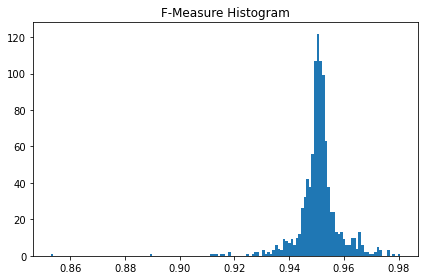

In [7]:
import matplotlib.pyplot as plt
from audace.plotters import save_fig

print("Mean   :", fmeasures.mean())
print("Median :", np.median(fmeasures))
print("std    :", fmeasures.std())
print("var    :", fmeasures.var())
print("Min    :", fmeasures.min())
print("Max    :", fmeasures.max())

_ = plt.hist(fmeasures, bins='auto')
plt.title("F-Measure Histogram")

figure_name = "F-Measure Histogram " + F" - ({DATASET_NAME}) - C{C} - G{GAMMA} -R{REPEAT}"

save_fig(EXP_NAME, figure_name)